# ライブラリ

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve,recall_score, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
# import xgboost as xgb
import json
import pickle
import csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import os

# 入出力

In [483]:
# file_pred = data_path/'tmp/202012061919_all.csv'
file_f = 'bt_features.csv'
# file_input_score = 'C:/Users/nishina/workspace/keiba_y/keiba/resource/model_build/logs/wh/202012191641/202012191641_all.csv'
file_input_score = 'C:/Users/nishina/workspace/keiba_y/keiba/resource/model_build/logs/wh/20201219_all.csv'

# 読み込み

In [4]:
file_hukusho_odds = '../../../resource/common/raw_result/odds/hukusho_odds.csv'

def parse_hukusho(file_hukusho_odds):
    df_hukusho = pd.read_csv(file_hukusho_odds)

    df_hukusho = df_hukusho.loc[df_hukusho.オッズ!='---.-']
    df_hukusho = df_hukusho.loc[df_hukusho.オッズ!='-3.0 - -3.0']
    df_hukusho.reset_index(drop=True, inplace=True)

    tmp = df_hukusho['オッズ'].str.split('-', expand=True)
    tmp.columns = ['複勝_odds', '_']

    df_hukusho = pd.concat([df_hukusho, tmp], axis=1)
    df_hukusho.複勝_odds = df_hukusho.複勝_odds.astype(str).str.strip().astype(np.float64)
    return df_hukusho

df_hukusho = parse_hukusho(file_hukusho_odds)

In [49]:
file_sanrenpuku_odds = '../../../resource/common/raw_result/odds/sanrenpuku_odds.csv'
df_sanrenpuku = pd.read_csv(file_sanrenpuku_odds, index_col=0)
df_sanrenpuku.reset_index(drop=True, inplace=True)
df_sanrenpuku.drop('選択', axis=1, inplace=True)

In [50]:
df_sanrenpuku = df_sanrenpuku.loc[df_sanrenpuku.オッズ!='---.-']

In [51]:
tmp = df_sanrenpuku['組み合わせ'].str.replace('  ', ' ').str.split(' ', expand=True)
tmp.columns = ['馬1', '馬2', '馬3']

In [52]:
for col in tmp.columns:
    tmp[col] = tmp[col].astype(int).astype(str).str.zfill(2)

In [53]:
df_sanrenpuku = pd.concat([df_sanrenpuku, tmp], axis=1)

In [54]:
df_sanrenpuku['三連複_key'] = df_sanrenpuku.race_id.astype(str) + df_sanrenpuku['馬1'] + df_sanrenpuku['馬2'] + df_sanrenpuku['馬3']

In [67]:
df_sanrenpuku.オッズ = df_sanrenpuku.オッズ.astype(float)

In [68]:
df_sanrenpuku.head(2)

,組み合わせ,オッズ,race_id,馬1,馬2,馬3,三連複_key
0,1 2 3,340.5,201209030111,01,02,03,201209030111010203
1,1 2 4,907.1,201209030111,01,02,04,201209030111010204


In [287]:
file_race_master = '../../../resource/common/race_info_master.csv'
df_info = pd.read_csv(
    file_race_master,
    usecols=['condition_int', 'weather_int', 'race_id', 'race_date', 'race_class_prize']
).set_index('race_id')
df_info.race_date = pd.to_datetime(df_info.race_date)
print(df_info.shape)
df_info.head(2)

(27125, 4)


,race_date,race_class_prize,condition_int,weather_int
race_id,,,,
201001020110,2010-09-11,オープン,1,2
201001020111,2010-09-11,2勝クラス,1,2


In [15]:
file_race_transaction = '../../../resource/common/race_result_transaction.csv'
df_result = pd.read_csv(file_race_transaction, usecols=['race_id', '馬名', 'odds', 'horse_id', 'course_num'])
print(df_result.shape)
df_result.head(2)

(387828, 5)


,course_num,馬名,odds,race_id,horse_id
0,3,マイネルギブソン,6.0,201001020110,1
1,10,ロビンフット,2.7,201001020110,2


In [485]:
df_pred = pd.read_csv(file_input_score, engine='python', encoding='cp932')
df_pred.head(2)

,arrival,race_id,horse_id,pred_prob
0,1,201201010101,3734,0.366520
1,8,201201010101,13840,0.053515


In [486]:
df_pred = df_pred.merge(df_result, how='left', on=['race_id', 'horse_id'])
print(df_pred.shape)
df_pred.head(2)

(148567, 7)


,arrival,race_id,horse_id,pred_prob,course_num,馬名,odds
0,1,201201010101,3734,0.366520,8,アウトシャイン,1.7
1,8,201201010101,13840,0.053515,4,グラマラスグロウ,7.4


In [487]:
df_pred.isnull().sum()

arrival       0
race_id       0
horse_id      0
pred_prob     0
course_num    0
馬名            0
odds          2
dtype: int64

In [488]:
df_pred = df_pred.merge(df_hukusho[['race_id', '馬名', '複勝_odds']], how='left', on=['race_id', '馬名'])

# 正解フラグ

In [489]:
df_pred['pred_rank'] = df_pred.groupby('race_id').pred_prob.rank(ascending=False, method='min')
accuracy_id = df_pred.query('(arrival==1) and (pred_rank==1)').race_id

In [490]:
df_pred['odds_rank'] = df_pred.groupby('race_id').odds.rank(ascending=True, method='min')

In [491]:
pd.crosstab(df_pred.arrival, df_pred.pred_rank).style.background_gradient()

pred_rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,2509,1793,1286,1089,868,699,544,419,335,263,212,153,105,86,63,36,17,5
2,1809,1606,1432,1112,938,760,632,513,450,351,249,206,155,104,87,46,20,11
3,1374,1383,1281,1119,1026,937,708,631,520,404,295,267,196,152,95,63,19,15
4,1027,1118,1135,1102,1045,930,840,673,585,484,408,340,267,187,139,95,50,31
5,829,903,1016,1016,1025,987,877,792,675,591,460,379,302,238,165,136,44,38
6,644,763,866,967,960,973,961,894,788,644,481,435,325,303,213,151,54,43
7,499,653,729,828,832,943,1013,996,877,699,609,521,383,316,220,187,75,44
8,407,540,631,727,850,854,943,1012,900,800,632,557,469,350,271,193,76,65
9,362,420,523,597,705,733,841,892,986,890,719,592,477,458,354,261,101,68


In [492]:
df_ac = pd.DataFrame(index=df_pred.race_id.unique())
df_ac.index.name = 'race_id'

In [493]:
tmp = df_pred.loc[(df_pred.pred_rank==1)&(df_pred.arrival==1)].race_id.value_counts()
df_ac['単勝'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp==1].index), '単勝'] = 1

In [494]:
tmp = df_pred.loc[(df_pred.pred_rank==1)&(df_pred.arrival<=3)].race_id.value_counts()
df_ac['複勝'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp==1].index), '複勝'] = 1

In [495]:
tmp = df_pred.loc[(df_pred.pred_rank<=2)&(df_pred.arrival<=2)].race_id.value_counts()
df_ac['馬連'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp==2].index), '馬連'] = 1

In [496]:
tmp1 = set(df_pred.loc[(df_pred.pred_rank==1)&(df_pred.arrival==1)].race_id)
tmp2 = set(df_pred.loc[(df_pred.pred_rank==2)&(df_pred.arrival==2)].race_id)
df_ac['馬単'] = 0
df_ac.loc[df_ac.index.isin(tmp1&tmp2), '馬単'] = 1

In [497]:
tmp1 = set(df_pred.loc[(df_pred.pred_rank==1)&(df_pred.arrival==1)].race_id)
tmp2 = set(df_pred.loc[(df_pred.pred_rank==3)&(df_pred.arrival==2)].race_id)
df_ac['馬単_2'] = 0
df_ac.loc[df_ac.index.isin(tmp1&tmp2), '馬単_2'] = 1

In [498]:
tmp = df_pred.loc[(df_pred.pred_rank<=2)&(df_pred.arrival<=3)].race_id.value_counts()
df_ac['ワイド'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp==2].index), 'ワイド'] = 1

In [499]:
tmp = df_pred.loc[(df_pred.pred_rank<=3)&(df_pred.arrival<=3)].race_id.value_counts()
df_ac['三連複'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp==3].index), '三連複'] = 1

In [581]:
tmp = df_pred.loc[(df_pred.pred_rank<=5)&(df_pred.arrival<=3)].race_id.value_counts()
df_ac['三連複2'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp>=3].index), '三連複2'] = 1

In [500]:
tmp1 = set(df_pred.loc[(df_pred.pred_rank==1)&(df_pred.arrival==1)].race_id)
tmp2 = set(df_pred.loc[(df_pred.pred_rank==2)&(df_pred.arrival==2)].race_id)
tmp3 = set(df_pred.loc[(df_pred.pred_rank==3)&(df_pred.arrival==3)].race_id)
df_ac['三連単'] = 0
df_ac.loc[df_ac.index.isin(tmp1&tmp2&tmp3), '三連単'] = 1

In [501]:
for col in df_ac.columns:
    print(col)
    print((df_ac[col] == 1).sum() / df_ac.shape[0])

単勝
0.23965994841914223
複勝
0.5437004489445029
馬連
0.10402139650396408
馬単
0.055401662049861494
馬単_2
0.04040500525360589
ワイド
0.22819753558123984
三連複
0.05683446365459929
三連単
0.011557932944884898


# 全馬券のモデル作る

In [503]:
tmp = pd.pivot_table(
    df_pred.query('pred_rank <=4'),
    values='pred_prob',
    index='race_id',
    columns='pred_rank'
)
tmp.columns = ['score1', 'score2', 'score3', 'score4']
df_ac = df_ac.merge(tmp, how='left', left_index=True, right_index=True)

<AxesSubplot:>

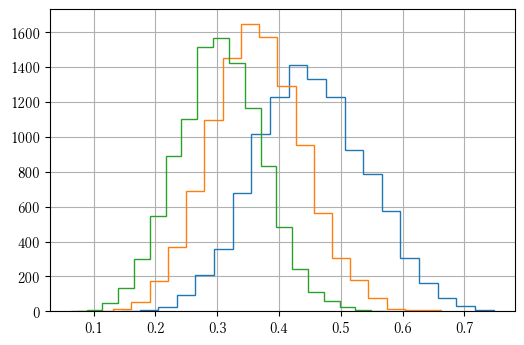

In [504]:
df_ac.score1.hist(bins=20, histtype='step')
df_ac.score2.hist(bins=20, histtype='step')
df_ac.score3.hist(bins=20, histtype='step')

In [505]:
df_ac['s_diff_12'] = df_ac.score1 - df_ac.score2
df_ac['s_diff_13'] = df_ac.score1 - df_ac.score3
df_ac['s_diff_23'] = df_ac.score2 - df_ac.score3
df_ac['s_diff_34'] = df_ac.score3 - df_ac.score4

In [506]:
data_list = []
for k,v in df_pred.groupby('race_id'):
    ss = pd.DataFrame(StandardScaler().fit_transform(v[['pred_prob']]), columns=['pred_ss'])
    tmp_data = pd.concat([
        v.reset_index(drop=True),
        ss.reset_index(drop=True)
    ], axis=1)
    data_list.append(tmp_data)
#     break

In [507]:
tmp_pred = pd.concat(data_list)

In [508]:
tmp_pred.head(2)

,arrival,race_id,horse_id,pred_prob,course_num,馬名,odds,複勝_odds,pred_rank,odds_rank,pred_ss
0,1,201201010101,3734,0.366520,8,アウトシャイン,1.7,1.1,3.0,1.0,0.910164
1,8,201201010101,13840,0.053515,4,グラマラスグロウ,7.4,1.6,7.0,3.0,-0.859862


In [509]:
tmp = pd.pivot_table(
    tmp_pred.query('pred_rank <=4'),
    values='pred_ss',
    index='race_id',
    columns='pred_rank'
)
tmp.columns = ['score1_ss', 'score2_ss', 'score3_ss', 'score4_ss']
df_ac = df_ac.merge(tmp, how='left', left_index=True, right_index=True)

<AxesSubplot:>

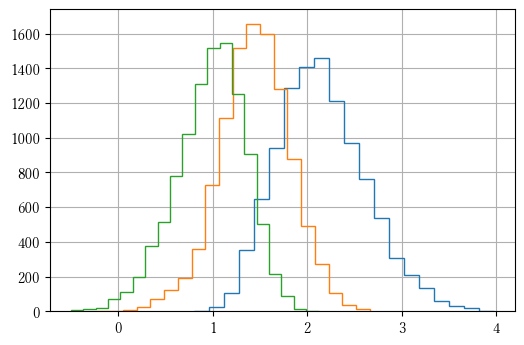

In [510]:
df_ac.score1_ss.hist(bins=20, histtype='step')
df_ac.score2_ss.hist(bins=20, histtype='step')
df_ac.score3_ss.hist(bins=20, histtype='step')

## オッズ付与

In [511]:
df_ac = df_ac.merge(
    df_pred.query('pred_rank==1')[['race_id', 'odds']].drop_duplicates('race_id').rename(columns={'odds':'odds1'}).set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

In [512]:
df_ac = df_ac.merge(
    df_pred.query('pred_rank==2')[['race_id', 'odds']].drop_duplicates('race_id').rename(columns={'odds':'odds2'}).set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

In [513]:
df_ac = df_ac.merge(
    df_pred.query('pred_rank==3')[['race_id', 'odds']].drop_duplicates('race_id').rename(columns={'odds':'odds3'}).set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

In [514]:
df_ac = df_ac.merge(
    df_pred.query('pred_rank==1')[['race_id', '複勝_odds']].drop_duplicates('race_id').set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

In [515]:
for k,v in df_pred.query('pred_rank <= 3').groupby('race_id'):
    key = str(k) + v.sort_values('course_num').course_num.astype(str).str.zfill(2).sum()
    df_ac.loc[k, '三連複_key'] = key

In [516]:
df_ac = df_ac.reset_index().merge(
    df_sanrenpuku[['三連複_key', 'オッズ']],
    how='left',
    on='三連複_key'
).rename(columns={'オッズ': '三連複_odds'}).set_index('race_id')

In [517]:
# df_ac['複勝_odds'] = 1.1
df_ac['馬連_odds'] = df_ac.odds1 * 1.5
df_ac['馬単_odds'] = df_ac.odds1 * df_ac.odds2 * 0.8
df_ac['馬単_2_odds'] = df_ac.odds1 * df_ac.odds3 * 0.8
df_ac['ワイド_odds'] = df_ac.odds1 * 0.7
# df_ac['三連複_odds'] = df_ac.odds1 * df_ac.odds2 * 0.9
df_ac['三連単_odds'] = df_ac.odds1 * df_ac.odds2 * df_ac.odds3 * 0.6

In [518]:
odds_cols = [
    'odds1',
    '複勝_odds',
    '馬連_odds',
    '馬単_odds',
    '馬単_2_odds',
    'ワイド_odds',
    '三連複_odds',
    '三連単_odds'
]
for col in odds_cols:
    print(col)
    df_ac.loc[df_ac[col]<1, col] = 1

odds1
複勝_odds
馬連_odds
馬単_odds
馬単_2_odds
ワイド_odds
三連複_odds
三連単_odds


In [519]:
acc_cols = [
    '単勝',
    '複勝',
    '馬連',
    '馬単',
    '馬単_2',
    'ワイド',
    '三連複',
    '三連単'
]

In [520]:
df_ac = df_ac.merge(
    df_pred.query('odds_rank==1').drop_duplicates('race_id')[
        ['race_id', 'odds', 'pred_prob']
    ].rename(columns={
        'odds': 'odds_p1',
        'pred_prob':'oddsp1_score'
    }).set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

In [521]:
df_ac['odds_p1_s_diff1'] = df_ac.oddsp1_score - df_ac.score1
df_ac['odds_p1_s_diff2'] = df_ac.oddsp1_score - df_ac.score2
df_ac['odds_p3_s_diff3'] = df_ac.oddsp1_score - df_ac.score3

In [522]:
df_ac = df_ac.merge(df_info, how='left', left_index=True, right_index=True)

In [523]:
df_ac = pd.get_dummies(df_ac, columns=['weather_int', 'condition_int'])

In [524]:
df_ac.corr().style.background_gradient()

,単勝,複勝,馬連,馬単,馬単_2,ワイド,三連複,三連単,score1,score2,score3,score4,s_diff_12,s_diff_13,s_diff_23,s_diff_34,score1_ss,score2_ss,score3_ss,score4_ss,odds1,odds2,odds3,複勝_odds,三連複_odds,馬連_odds,馬単_odds,馬単_2_odds,ワイド_odds,三連単_odds,odds_p1,oddsp1_score,odds_p1_s_diff1,odds_p1_s_diff2,odds_p3_s_diff3,weather_int_1,weather_int_2,weather_int_3,condition_int_1,condition_int_2,condition_int_3
単勝,1.000000,0.514327,0.234556,0.431364,0.365494,0.231114,0.082540,0.192606,0.128733,0.026359,-0.039225,-0.052955,0.123870,0.156480,0.083265,0.015264,0.097939,-0.036955,-0.105373,-0.098155,-0.193460,0.018567,0.034254,-0.179202,-0.063887,-0.193460,-0.089057,-0.086336,-0.192955,-0.044569,-0.165440,0.210996,0.159974,0.212350,0.230782,-0.006424,-0.005232,0.028761,0.011081,-0.009171,-0.005661
複勝,0.514327,1.000000,0.312146,0.221862,0.187983,0.498136,0.224883,0.099063,0.160964,0.047049,-0.036150,-0.078367,0.141048,0.185893,0.107254,0.055052,0.087473,-0.058218,-0.142468,-0.160998,-0.257587,0.001511,0.027865,-0.254026,-0.095130,-0.257587,-0.124280,-0.119065,-0.257298,-0.067554,-0.199409,0.235737,0.163093,0.226054,0.253767,-0.005308,-0.006086,0.028040,0.003571,-0.002852,-0.002010
馬連,0.234556,0.312146,1.000000,0.710764,-0.068329,0.626628,0.259614,0.317360,0.096054,0.068818,-0.014812,-0.065639,0.044166,0.105811,0.110380,0.069037,0.016348,-0.001565,-0.087325,-0.124025,-0.106240,-0.098821,0.012925,-0.108474,-0.071648,-0.106240,-0.084951,-0.045752,-0.106022,-0.052292,-0.132928,0.144700,0.102619,0.113351,0.151850,0.002133,-0.008864,0.016158,0.001907,0.000193,-0.004178
馬単,0.431364,0.221862,0.710764,1.000000,-0.047574,0.445385,0.160574,0.446505,0.090855,0.052313,-0.012793,-0.045222,0.054325,0.099163,0.085779,0.043727,0.029674,-0.011571,-0.077188,-0.094330,-0.091821,-0.054241,0.010897,-0.089030,-0.048539,-0.091821,-0.060120,-0.042598,-0.091525,-0.035134,-0.108028,0.128501,0.086061,0.106260,0.134659,0.005762,-0.013757,0.018943,0.009818,-0.008507,-0.004326
馬単_2,0.365494,0.187983,-0.068329,-0.047574,1.000000,0.010949,0.171724,-0.022189,0.065425,0.027065,0.017187,-0.005867,0.049533,0.051417,0.015298,0.033611,0.019912,-0.022922,-0.025861,-0.041667,-0.074093,0.016056,-0.048953,-0.071873,-0.042879,-0.074093,-0.032205,-0.053526,-0.073714,-0.032082,-0.075049,0.092843,0.062379,0.083600,0.083257,0.000886,0.002942,-0.009350,0.002714,0.002641,-0.010229
ワイド,0.231114,0.498136,0.626628,0.445385,0.010949,1.000000,0.451450,0.198867,0.126810,0.097176,-0.006228,-0.075454,0.052100,0.129601,0.137922,0.095368,0.008108,-0.004460,-0.118234,-0.168253,-0.141606,-0.131934,0.006026,-0.153480,-0.103657,-0.141606,-0.119102,-0.067909,-0.141355,-0.075756,-0.163626,0.167576,0.104631,0.120153,0.170055,-0.009063,0.006522,0.006861,-0.002071,0.004845,-0.004606
三連複,0.082540,0.224883,0.259614,0.160574,0.171724,0.451450,1.000000,0.440507,0.083912,0.072238,0.025684,-0.040643,0.026684,0.063189,0.065495,0.094415,-0.024248,-0.025138,-0.061389,-0.116428,-0.076729,-0.062817,-0.062709,-0.084200,-0.065705,-0.076729,-0.058636,-0.061348,-0.076492,-0.047840,-0.106711,0.100385,0.055424,0.063054,0.086250,-0.006514,0.007618,-0.002176,0.003019,-0.001648,-0.003081
三連単,0.192606,0.099063,0.317360,0.446505,-0.022189,0.198867,0.440507,1.000000,0.058832,0.034088,-0.007072,-0.034700,0.034968,0.063294,0.054351,0.037621,0.006164,-0.018542,-0.050014,-0.066025,-0.047430,-0.032733,-0.008774,-0.046732,-0.029177,-0.047430,-0.030533,-0.026949,-0.047210,-0.020665,-0.062671,0.069262,0.037387,0.053526,0.072674,0.002991,-0.000209,-0.006976,0.015109,-0.016965,0.000354
score1,0.128733,0.160964,0.096054,0.090855,0.065425,0.126810,0.083912,0.058832,1.000000,0.576643,0.364246,0.215459,0.597083,0.708993,0.328309,0.241262,0.410985,-0.098690,-0.249758,-0.287574,-0.239349,-0.078989,-0.024718,-0.263659,-0.177192,-0.239349,-0.162124,-0.146441,-0.238968,-0.116627,-0.253905,0.650843,-0.056802,0.339927,0.454204,-0.002156,-0.002642,0.011801,-0.021607,0.012441,0.020882
score2,0.026359,0.047049,0.068818,0.052313,0.027065,0.097176,0.072238,0.034088,0.576643,1.000000,0.

## 週クラスター

In [525]:
from sklearn.cluster import KMeans

In [526]:
df_ac['race_date'] = df_ac.race_date.dt.week

In [527]:
df_cnt = df_ac.groupby('race_date')[['単勝', '複勝', '馬連', '馬単', 'ワイド', '三連複', '三連単']].sum()
df_cnt['cnt'] = df_ac.race_date.value_counts()
df_rate = df_cnt[['単勝', '複勝', '馬連', '馬単', 'ワイド', '三連複', '三連単']].div(df_cnt.cnt, axis=0)
df_rate_m = (df_rate - (df_cnt.sum() / df_cnt.cnt.sum()).drop('cnt'))

In [528]:
df_cnt

,単勝,複勝,馬連,馬単,ワイド,三連複,三連単,cnt
race_date,,,,,,,,
1,12,59,13,4,27,7,0,112
2,35,73,14,8,28,7,5,152
3,41,95,12,5,34,9,2,194
4,47,97,29,17,47,12,4,170
5,39,72,14,9,29,4,1,128
6,32,81,20,10,36,4,1,152
7,50,99,12,10,34,6,0,202
8,48,105,21,11,49,17,4,204
9,55,115,22,13,59,14,4,203


## 雑に全部作る

In [383]:
def get_balanced_data(df, target_col):
    s_rate = (df[target_col] == 1).sum() / df.shape[0]
    df_train, df_test = train_test_split(df, test_size=int(df.shape[0]*s_rate*0.7), random_state=0, stratify=df[target_col])
    if  s_rate > 0.4:
        return s_rate, df_train, df_test
    # 不均衡データ調整
    target_size = (df_train[target_col]==1).sum()

    df_train_0 = df_train[df_train[target_col]==0]
    df_train_use = df_train_0.sample(target_size, random_state=0)
    df_train_use = pd.concat([df_train_use, df_train[df_train[target_col]==1]])

    tmp = df_train_use[[target_col]]
    tmp['種類'] = 'train'
    tmp2 = df_test[[target_col]]
    tmp2['種類'] = 'test'
    tmp3 = pd.concat([tmp, tmp2])
    df_sampling = pd.crosstab(tmp3.種類, tmp3[target_col], margins=True)
    display(df_sampling)

    s_rate = df_test[target_col].sum() / len(df_test[target_col])
    return s_rate, df_train, df_test

In [384]:
def plot_calibration(y_test, prob2, filename=None):
    prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=prob2, n_bins=20)

    fig, ax1 = plt.subplots()
    ax1.plot(prob_pred, prob_true, marker='s', label='calibration plot', color='skyblue')
    ax1.plot([0, 1], [0, 1], linestyle='--', label='ideal', color='limegreen')
    ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
    ax2 = ax1.twinx()
    ax2.hist(prob2, bins=20, histtype='step', color='orangered')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('score')
    ax2.set_ylabel('frequency')
    if not filename is None:
        fig.savefig(filename, bbox_inches='tight', pad_inche=.05)
    plt.show()
    plt.clf()

In [454]:
def get_return(df, pred_col, odds_col, hue_col, vmax=1, step=0.01, over=True, plot_min=0.8):
    df_ret = pd.DataFrame(columns=['対象数', '回収率'])
    if over:
        op = '>'
    else:
        op = '<'
    max_ret = -10000
    max_th = -1
    max_len = -1
    for th in np.arange(0, vmax, step):
        th = round(th, 4)
        tmp = df.query(pred_col + op + str(th))
        ret = round((tmp.query(hue_col+'==1')[odds_col].sum()/tmp.shape[0]), 4)
        if ret > max_ret:
            max_ret = ret
            max_th = th
            max_len = len(tmp)
        df_ret.loc[th] = [tmp.shape[0], ret]
    print(f'対象カラム: {pred_col}, 最大回収率: {max_ret}, 閾値: {max_th}, 対象数: {max_len}, 対象率: {round(max_len/df.shape[0], 3)}')
    
    df_ret['対象率'] = df_ret.対象数 / df.shape[0]
    
#     plt.scatter(max_th, max_ret, s=100, c='none', edgecolors='blue')
    df_ret.回収率.plot()
    plt.plot([0,vmax], [1,1])
    plt.ylim(plot_min, )
    plt.ylabel('回収率')
    plt.xlabel(pred_col)
    plt.twinx()
    df[pred_col].hist(bins=20, alpha=.1, color='c', grid=False, range=(0, vmax))
    plt.ylabel('件数')
    plt.show()
    return df_ret, max_th

In [386]:
acc_cols

['単勝', '複勝', '馬連', '馬単', '馬単_2', 'ワイド', '三連複', '三連単']

In [387]:
odds_cols

['odds1',
 '複勝_odds',
 '馬連_odds',
 '馬単_odds',
 '馬単_2_odds',
 'ワイド_odds',
 '三連複_odds',
 '三連単_odds']

In [388]:
df_use

,単勝,複勝,馬連,馬単,馬単_2,ワイド,三連複,三連単,score1,score2,score3,score4,s_diff_12,s_diff_13,s_diff_23,s_diff_34,score1_ss,score2_ss,score3_ss,score4_ss,odds1,odds2,odds3,複勝_odds,三連複_key,...,odds_p1,oddsp1_score,odds_p1_s_diff1,odds_p1_s_diff2,odds_p3_s_diff3,race_date,weather_int_1,weather_int_2,weather_int_3,condition_int_1,condition_int_2,condition_int_3,race_class_prize_1勝クラス,race_class_prize_2勝クラス,race_class_prize_3勝クラス,race_class_prize_G1,race_class_prize_G2,race_class_prize_G3,race_class_prize_オープン,race_class_prize_未勝利,三連複_pred,三連複_EV,三連複_100_buy,三連複_120_buy,三連複_150_buy
race_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
201201010101,0,0,0,0,0,0,0,0,0.414462,0.405594,0.343583,0.271479,0.008868,0.070879,0.062011,0.072104,1.432643,1.376841,0.986642,0.532932,5.9,7.6,1.7,1.3,201201010101030809,...,1.7,0.343583,-0.070879,-0.062011,0.000000,29,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0.149097,1.058592,1,1,0
201201010104,1,1,0,0,1,0,0,0,0.452583,0.369634,0.327322,0.270735,0.082949,0.125261,0.042312,0.056587,2.103530,1.436887,1.096838,0.642066,3.7,5.0,6.1,1.3,201201010104070812,...,2.7,0.270735,-0.181847,-0.098898,-0.056587,29,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0.069966,1.497279,1,1,1
201201010108,0,0,0,0,0,0,0,0,0.488226,0.413168,0.345950,0.288788,0.075058,0.142277,0.067218,0.057162,2.117476,1.579652,1.098006,0.688418,2.7,9.6,5.5,1.4,201201010108010204,...,2.7,0.488226,0.000000,0.075058,0.142277,29,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.054237,0.737624,1,0,0
201201010110,0,1,0,0,0,0,0,0,0.377619,0.296141,0.242853,0.220939,0.081478,0.134766,0.053288,0.021914,1.519487,0.722328,0.200974,-0.013426,3.7,4.5,6.8,1.6,201201010110010203,...,2.4,0.220939,-0.156680,-0.075202,-0.021914,29,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0.116987,2.023880,1,1,1
201201010112,0,0,0,0,0,0,0,0,0.522026,0.392713,0.257643,0.255642,0.129313,0.264383,0.135070,0.002001,2.524760,1.603486,0.641195,0.626942,2.2,3.4,17.8,1.2,201201010112020814,...,2.2,0.522026,0.000000,0.129313,0.264383,29,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.050645,0.916675,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021206,0,1,0,0,0,0,0,0,0.551088,0.353093,0.325722,0.314192,0.197995,0.225366,0.027371,0.011530,2.656262,1.131899,0.921173,0.832400,1.8,19.9,11.6,1.1,201910021206021016,...,1.8,0.551088,0.000000,0.197995,0.225366,35,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0.029396,1.702008,1,1,1
201910021208,0,0,0,0,0,0,0,0,0.370685,0.327255,0.308420,0.237418,0.043430,0.062265,0.018836,0.071002,1.959843,1.520824,1.330421,0.612680,8.1,2.3,3.9,1.7,201910021208020815,...,2.3,0.327255,-0.043430,0.000000,0.018836,35,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0.060475,0.997838,1,1,0
201910021209,0,1,0,0,0,1,0,0,0.415797,0.370376,0.313456,0.282246,0.045421,0.102341,0.056920,0.031210,2.107299,1.680626,1.145935,0.852753,4.2,15.7,7.3,1.4,201910021209031012,...,3.6,0.282246,-0.133551,-0.088130,-0.031210,35,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0.015478,0.759968,1,1,0


----------------------------------------
単勝 odds1


target,0,1,All
種類,,,
test,1312,413,1725
train,2052,2052,4104
All,3364,2465,5829


,0
score1,0.0
score2,0.0
score3,0.0
score4,0.0
s_diff_12,0.0
s_diff_13,0.0
s_diff_23,0.0
s_diff_34,0.0
score1_ss,0.0
score2_ss,0.0


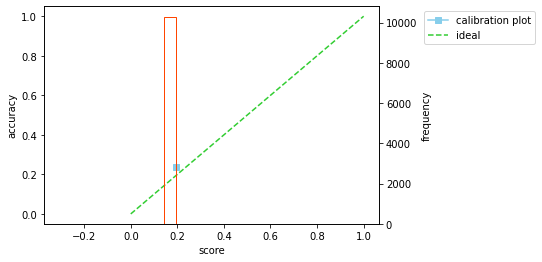

AUC 0.5
対象カラム: EV, 最大回収率: 0.9, 閾値: 1.6, 対象数: 1671, 対象率: 0.162


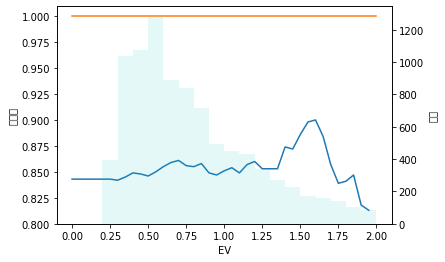

単勝 odds1
----------------------------------------


----------------------------------------
複勝 複勝_odds


,0
score1,3.363008e-36
score2,1.800664e-36
score3,8.211143e-37
score4,1.677517e-37
s_diff_12,1.562345e-36
s_diff_13,2.541894e-36
s_diff_23,9.795493e-37
s_diff_34,6.533626e-37
score1_ss,1.446131e-35
score2_ss,3.965804e-36


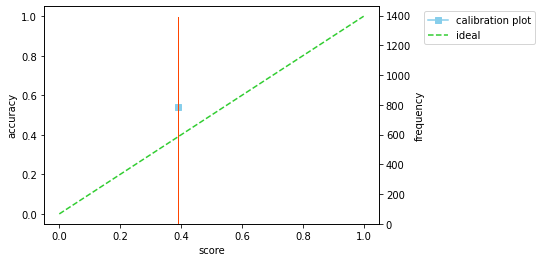

AUC 0.5037147360459665
対象カラム: EV, 最大回収率: 0.896, 閾値: 1.35, 対象数: 475, 対象率: 0.046


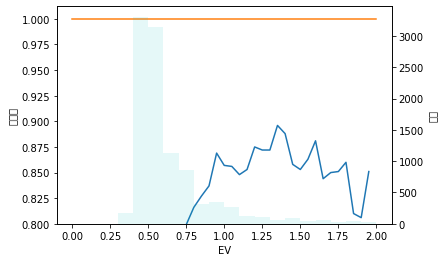

複勝 複勝_odds
----------------------------------------


----------------------------------------
馬連 馬連_odds


target,0,1,All
種類,,,
test,634,68,702
train,935,935,1870
All,1569,1003,2572


,0
score1,0.0
score2,0.0
score3,0.0
score4,0.0
s_diff_12,0.0
s_diff_13,0.0
s_diff_23,0.0
s_diff_34,0.0
score1_ss,0.0
score2_ss,0.0


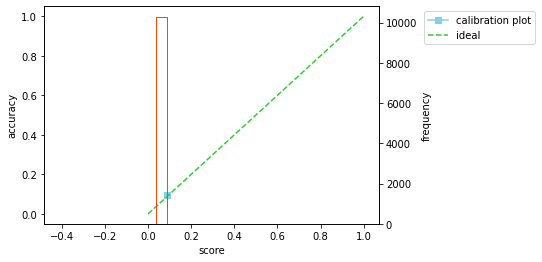

AUC 0.5
対象カラム: EV, 最大回収率: 0.597, 閾値: 1.9, 対象数: 679, 対象率: 0.066


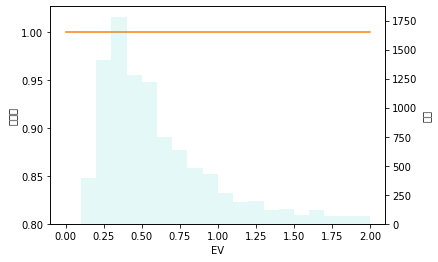

馬連 馬連_odds
----------------------------------------


----------------------------------------
馬単 馬単_odds


target,0,1,All
種類,,,
test,358,20,378
train,521,521,1042
All,879,541,1420


,0
score1,0.0
score2,0.0
score3,0.0
score4,0.0
s_diff_12,0.0
s_diff_13,0.0
s_diff_23,0.0
s_diff_34,0.0
score1_ss,0.0
score2_ss,0.0


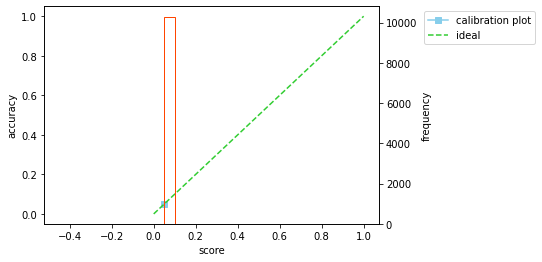

AUC 0.5
対象カラム: EV, 最大回収率: 1.101, 閾値: 1.95, 対象数: 2392, 対象率: 0.233


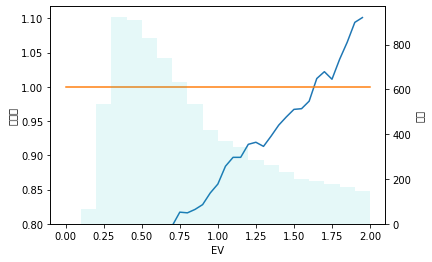

馬単 馬単_odds
----------------------------------------


----------------------------------------
馬単_2 馬単_2_odds


target,0,1,All
種類,,,
test,294,13,307
train,427,427,854
All,721,440,1161


,0
score1,0.0
score2,0.0
score3,0.0
score4,0.0
s_diff_12,0.0
s_diff_13,0.0
s_diff_23,0.0
s_diff_34,0.0
score1_ss,0.0
score2_ss,0.0


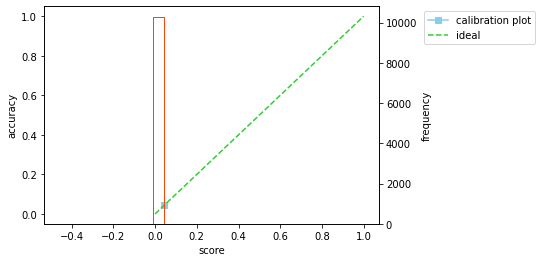

AUC 0.5
対象カラム: EV, 最大回収率: 1.278, 閾値: 1.95, 対象数: 2760, 対象率: 0.268


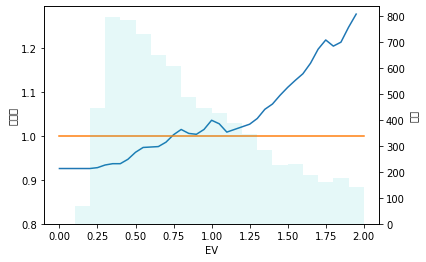

馬単_2 馬単_2_odds
----------------------------------------


----------------------------------------
ワイド ワイド_odds


target,0,1,All
種類,,,
test,1247,357,1604
train,1935,1935,3870
All,3182,2292,5474


,0
score1,0.0
score2,0.0
score3,0.0
score4,0.0
s_diff_12,0.0
s_diff_13,0.0
s_diff_23,0.0
s_diff_34,0.0
score1_ss,0.0
score2_ss,0.0


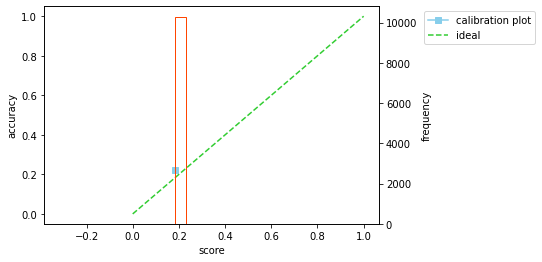

AUC 0.5
対象カラム: EV, 最大回収率: 0.891, 閾値: 1.85, 対象数: 662, 対象率: 0.064


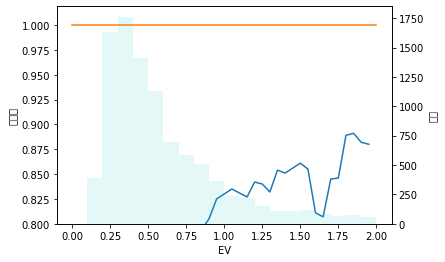

ワイド ワイド_odds
----------------------------------------


----------------------------------------
三連複 三連複_odds


target,0,1,All
種類,,,
test,365,21,386
train,531,531,1062
All,896,552,1448


,0
score1,0.0
score2,0.0
score3,0.0
score4,0.0
s_diff_12,0.0
s_diff_13,0.0
s_diff_23,0.0
s_diff_34,0.0
score1_ss,0.0
score2_ss,0.0


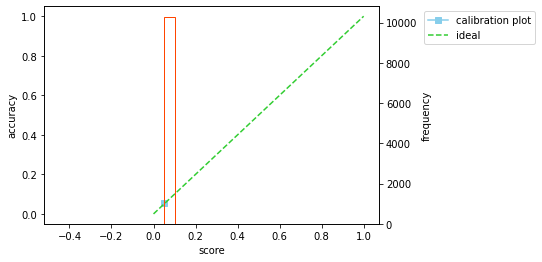

AUC 0.5
対象カラム: EV, 最大回収率: 1.248, 閾値: 1.9, 対象数: 3646, 対象率: 0.354


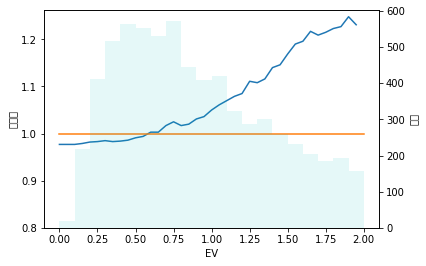

三連複 三連複_odds
----------------------------------------


----------------------------------------
三連単 三連単_odds


target,0,1,All
種類,,,
test,81,1,82
train,117,117,234
All,198,118,316


,0
score1,0.0
score2,0.0
score3,0.0
score4,0.0
s_diff_12,0.0
s_diff_13,0.0
s_diff_23,0.0
s_diff_34,0.0
score1_ss,0.0
score2_ss,0.0


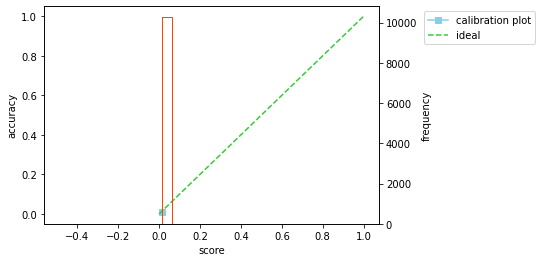

AUC 0.5
対象カラム: EV, 最大回収率: 1.685, 閾値: 1.95, 対象数: 3818, 対象率: 0.371


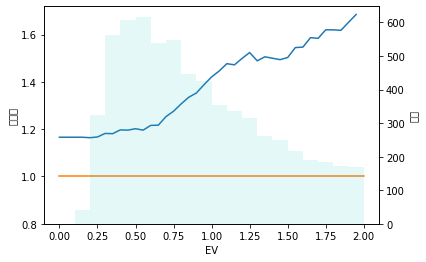

三連単 三連単_odds
----------------------------------------




In [156]:
for target_col, odds_col in zip(acc_cols, odds_cols):
    print('-'*40)
    print(target_col, odds_col)
    df_use = df_ac.copy().dropna()
    X_cols = [col for col in df_use.columns if col not in acc_cols]
    df_use['target'] = df_use[target_col].copy()
    s_rate, df_train, df_test = get_balanced_data(df_use, 'target')
    X_train = df_train[X_cols]
    X_test = df_test[X_cols]
    y_train = df_train['target']
    y_test = df_test['target']

    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train)
    display(pd.Series(clf.coef_[0], X_train.columns).to_frame())
#     y_pred_prob = clf.predict_proba(X_test)[:, 1]
#     prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
#     df_test['pred'] = prob2
#     plot_calibration(y_test, prob2)
#     print('AUC', roc_auc_score(y_test, y_pred_prob))
#     df_ret, max_th = get_return(df_test, 'pred', odds_col, target_col ,vmax=1, step=0.01, over=True, plot_min=0.8)


    y_pred_prob = clf.predict_proba(df_use[X_cols])[:, 1]
    prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
    df_use['pred'] = prob2
    plot_calibration(df_use['target'], prob2)
    print('AUC', roc_auc_score(df_use['target'], y_pred_prob))
#     df_ret, max_th = get_return(df_use, 'pred', odds_col, target_col ,vmax=1, step=0.01, over=True, plot_min=0.8)
    df_use['EV'] = df_use.pred * df_use[odds_col]
    df_ret, max_th = get_return(df_use, 'EV', odds_col, target_col ,vmax=min(df_use.EV.max(), 2), step=0.05, over=True, plot_min=0.8)
    
    print(target_col, odds_col)
    print('-'*40)
    print()
    print()

利用できるモデル  
- 馬連
  - AUC 0.744
  - 回収率 1.5くらい(EV 0.6)
- ワイド
  - AUC 0.713
  - 回収率 1.25くらい(EV 0.5)
- 三連複
  - AUC 0.770
  - 回収率 1.5くらい(EV 0.5)
  - 回収率 2くらい(EV 0.75)
- 三連単
  - AUC 0.788
  - 回収率 1.5くらい(EV 0.5)
  - 回収率 2くらい(EV 0.75)

利用できないモデル  
- 単勝
  - 馬モデルが要変更
- 複勝
  - 正確なオッズ入手により変わるかも
- 馬単
  - EVに対する回収率が安定しない

## 閾値を見る

In [389]:
def get_wk(col, n=4):
    km = KMeans(
        n_clusters=n,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=0.0001,
        precompute_distances='auto',
        verbose=0,
        random_state=0,
    #     copy_x=True,
    #     n_jobs=1
    )
#     name = col + '_label'
    name = 'label'
    df_rate[name] = km.fit_predict(df_rate[[col]])
    return df_rate[[name]]

In [390]:
import pathlib
resource_path = pathlib.Path('../../../resource')
model_path = resource_path /'common/model/BettingTicket'

In [391]:
def output_model(model, target_col, y_test, prob2, s_rate, X_cols):
    log_path = model_path / target_col
    os.makedirs(log_path/'image', exist_ok=True)
    pickle.dump(model,open(log_path/'model.pickle', 'wb'))

    plot_calibration(y_test, prob2, log_path/'image/calibration_plot.png')
#     plot_roc(y_test, prob2, log_path/'image/roc_plot.png')
    with open(log_path/'model_config.json', 'w') as f:
        json.dump({
                'X_cols':X_cols,
                'target_col': target_col,
                'params': model.get_params(),
                's_rate': s_rate,
                'AUC': roc_auc_score(y_test, prob2)
            },
            f,
            indent=4
        )

In [392]:
# df_ac = df_ac.merge(df_info[['race_class_prize']], how='left', left_index=True, right_index=True)

In [393]:
df_use = df_ac.copy().dropna()

In [396]:
df_th = pd.DataFrame(columns=['ret100_th', 'ret100_rate','ret120_th', 'ret120_rate','ret150_th', 'ret150_rate'])

In [397]:
df_use = pd.get_dummies(df_use, columns=['race_class_prize'])

In [398]:
tmp = pd.crosstab(df_ac.race_class_prize, df_ac.三連複, margins=True)
tmp['ac_rate'] = tmp[1] / tmp.All
tmp

三連複,0,1,All,ac_rate
race_class_prize,,,,
1勝クラス,3116,140,3256,0.042998
2勝クラス,1546,116,1662,0.069795
3勝クラス,705,24,729,0.032922
G1,138,6,144,0.041667
G2,221,15,236,0.063559
G3,376,10,386,0.025907
オープン,491,35,526,0.066540
未勝利,3290,240,3530,0.067989
All,9883,586,10469,0.055975


In [399]:
df_use.columns.tolist()

['単勝',
 '複勝',
 '馬連',
 '馬単',
 '馬単_2',
 'ワイド',
 '三連複',
 '三連単',
 'score1',
 'score2',
 'score3',
 'score4',
 's_diff_12',
 's_diff_13',
 's_diff_23',
 's_diff_34',
 'score1_ss',
 'score2_ss',
 'score3_ss',
 'score4_ss',
 'odds1',
 'odds2',
 'odds3',
 '複勝_odds',
 '三連複_key',
 '三連複_odds',
 '馬連_odds',
 '馬単_odds',
 '馬単_2_odds',
 'ワイド_odds',
 '三連単_odds',
 'odds_p1',
 'oddsp1_score',
 'odds_p1_s_diff1',
 'odds_p1_s_diff2',
 'odds_p3_s_diff3',
 'race_date',
 'weather_int_1',
 'weather_int_2',
 'weather_int_3',
 'condition_int_1',
 'condition_int_2',
 'condition_int_3',
 'race_class_prize_1勝クラス',
 'race_class_prize_2勝クラス',
 'race_class_prize_3勝クラス',
 'race_class_prize_G1',
 'race_class_prize_G2',
 'race_class_prize_G3',
 'race_class_prize_オープン',
 'race_class_prize_未勝利']

### 複勝

In [164]:
X_cols = [
 'score1',
 'score2',
 'score3',
 'score4',
 's_diff_12',
 's_diff_13',
 's_diff_23',
 's_diff_34',
#  'score1_ss',
#  'score2_ss',
#  'score3_ss',
#  'score4_ss',
 'odds1',
#  'odds2',
#  'odds3',
 '複勝_odds',
 '馬連_odds',
#  '馬単_odds',
#  '馬単_2_odds',
 'ワイド_odds',
#  '三連複_odds',
#  '三連単_odds',
 'odds_p1',
 'oddsp1_score',
 'odds_p1_s_diff1',
 'odds_p1_s_diff2',
 'odds_p3_s_diff3',
 'weather_int_1',
 'weather_int_2',
 'weather_int_3',
 'condition_int_1',
 'condition_int_2',
 'condition_int_3',
'label_0', 
'label_1',
'label_2',
'label_3', 
]

----------------------------------------
複勝 複勝_odds


,0
score1,0.231132
score2,0.112383
score3,-0.138778
score4,-0.798378
s_diff_12,0.118749
s_diff_13,0.369909
s_diff_23,0.251161
s_diff_34,0.659601
odds1,-0.073420
複勝_odds,0.098492


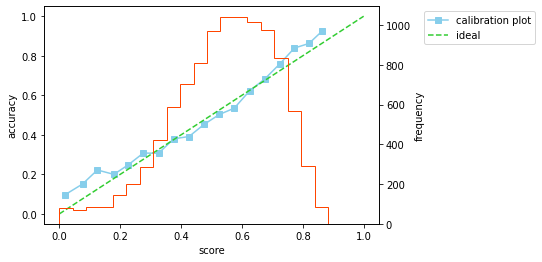

AUC 0.7039706509128744
対象カラム: 複勝_EV, 最大回収率: 1.034, 閾値: 1.2, 対象数: 88, 対象率: 0.009


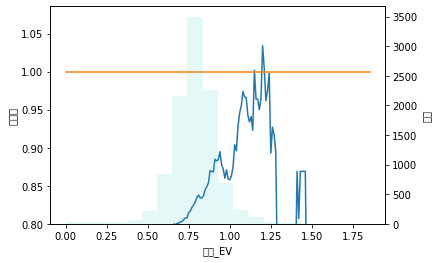

複勝 複勝_odds
----------------------------------------




In [169]:
target_col = '複勝'
odds_col = '複勝_odds'
print('-'*40)
print(target_col, odds_col)
df_use_c = df_use.copy()

df_use_c = df_use_c.merge(get_wk(target_col), how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
s_rate = 1
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(df_use[target_col], y_pred_prob))
#     df_ret, max_th = get_return(df_use, 'pred', odds_col, target_col ,vmax=1, step=0.01, over=True, plot_min=0.8)

ev_col = target_col + '_EV'
df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, odds_col, target_col ,vmax=min(df_use[ev_col].max(), 2), step=0.01, over=True, plot_min=0.8)

print(target_col, odds_col)
print('-'*40)
print()
print()

In [170]:
df_th.loc[ev_col] = [
df_ret.query('回収率>=1').index[0],
df_ret.query('回収率>=1').対象率.values[0],
df_ret.query('回収率>=1.2').index[0],
df_ret.query('回収率>=1.2').対象率.values[0],
df_ret.query('回収率>=1.5').index[0],
df_ret.query('回収率>=1.5').対象率.values[0]
]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [160]:
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate
複勝_EV,1.0,0.039625,1.16,0.010528,1.41,0.002297


対象カラム: 複勝_pred, 最大回収率: 1.029, 閾値: 0.88, 対象数: 14, 対象率: 0.001


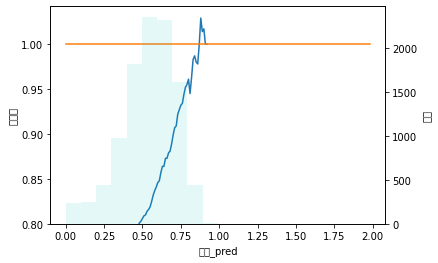

In [161]:
df_ret, max_th = get_return(df_use, pred_col, odds_col, target_col ,vmax=min(df_use[ev_col].max(), 2), step=0.01, over=True, plot_min=0.8)

### 馬連

In [171]:
X_cols = [
 'score1',
 'score2',
#  'score3',
 'score4',
 's_diff_12',
 's_diff_13',
 's_diff_23',
 's_diff_34',
#  'score1_ss',
#  'score2_ss',
#  'score3_ss',
#  'score4_ss',
 'odds1',
 'odds2',
#  'odds3',
#  '複勝_odds',
 '馬連_odds',
#  '馬単_odds',
#  '馬単_2_odds',
 'ワイド_odds',
#  '三連複_odds',
#  '三連単_odds',
 'odds_p1',
 'oddsp1_score',
 'odds_p1_s_diff1',
 'odds_p1_s_diff2',
 'odds_p3_s_diff3',
 'weather_int_1',
 'weather_int_2',
 'weather_int_3',
 'condition_int_1',
 'condition_int_2',
 'condition_int_3',
'label_0', 
'label_1',
'label_2',
'label_3', 
# 'label_4'
]

In [172]:
pd.options.display.max_rows=100

----------------------------------------
馬連 馬連_odds


馬連,0,1,All
種類,,,
test,634,68,702
train,935,935,1870
All,1569,1003,2572


,0
score1,0.419111
score2,0.660782
score4,-0.881599
s_diff_12,-0.241671
s_diff_13,0.366336
s_diff_23,0.608007
s_diff_34,0.934374
odds1,-0.149205
odds2,-0.085214
馬連_odds,-0.223807


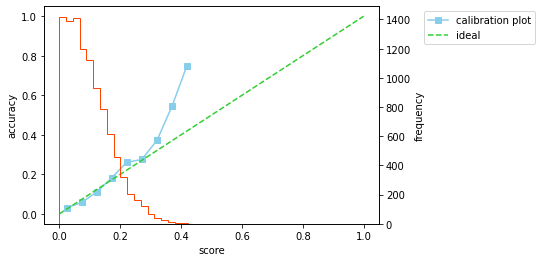

AUC 0.7350679249274257
対象カラム: 馬連_EV, 最大回収率: 2.456, 閾値: 1.92, 対象数: 32, 対象率: 0.003


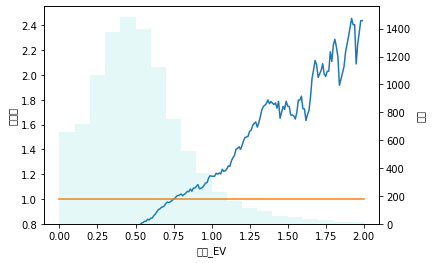

馬連 馬連_odds
----------------------------------------




In [173]:
target_col = '馬連'
odds_col = '馬連_odds'
print('-'*40)
print(target_col, odds_col)
df_use_c = df_use.copy()

df_use_c = df_use_c.merge(get_wk(target_col, 5), how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
s_rate = 1
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(df_use[target_col], y_pred_prob))

ev_col = target_col + '_EV'
df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, odds_col, target_col ,vmax=min(df_use[ev_col].max(), 2), step=0.01, over=True, plot_min=0.8)

print(target_col, odds_col)
print('-'*40)
print()
print()

In [174]:
df_th.loc[ev_col] = [
df_ret.query('回収率>=1').index[0],
df_ret.query('回収率>=1').対象率.values[0],
df_ret.query('回収率>=1.2').index[0],
df_ret.query('回収率>=1.2').対象率.values[0],
df_ret.query('回収率>=1.5').index[0],
df_ret.query('回収率>=1.5').対象率.values[0]
]

In [175]:
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate
馬連_EV,0.75,0.199553,1.03,0.073581,1.23,0.037714


In [176]:
# EVのほうがよい

### ワイド

In [177]:
X_cols = [
 'score1',
 'score2',
 'score3',
 'score4',
#  's_diff_12',
 's_diff_13',
 's_diff_23',
 's_diff_34',
 'score1_ss',
 'score2_ss',
 'score3_ss',
 'score4_ss',
 'odds1',
 'odds2',
#  'odds3',
 '複勝_odds',
 '馬連_odds',
#  '馬単_odds',
#  '馬単_2_odds',
 'ワイド_odds',
#  '三連複_odds',
#  '三連単_odds',
 'odds_p1',
 'oddsp1_score',
 'odds_p1_s_diff1',
 'odds_p1_s_diff2',
 'odds_p3_s_diff3',
 'weather_int_1',
 'weather_int_2',
 'weather_int_3',
 'condition_int_1',
 'condition_int_2',
 'condition_int_3',
'label_0', 
'label_1',
'label_2',
'label_3', 
'label_4',
]

----------------------------------------
ワイド ワイド_odds


ワイド,0,1,All
種類,,,
test,1247,357,1604
train,1935,1935,3870
All,3182,2292,5474


,0
score1,0.380462
score2,0.390315
score3,0.176636
score4,-0.095658
s_diff_13,0.203826
s_diff_23,0.213678
s_diff_34,0.272294
score1_ss,-0.170722
score2_ss,-0.080734
score3_ss,0.064504


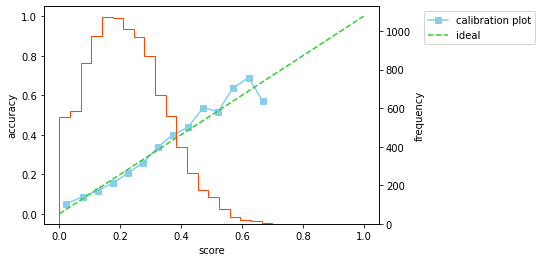

AUC 0.7132463483050426
対象カラム: ワイド_EV, 最大回収率: 2.288, 閾値: 2.12, 対象数: 35, 対象率: 0.003


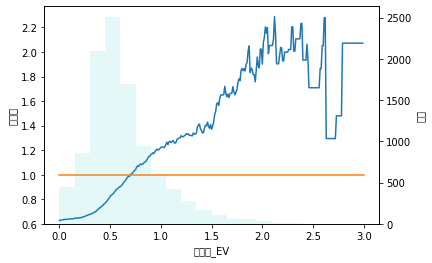

ワイド ワイド_odds
----------------------------------------




In [178]:
target_col = 'ワイド'
odds_col = 'ワイド_odds'
print('-'*40)
print(target_col, odds_col)
df_use_c = df_use.copy()

df_use_c = df_use_c.merge(get_wk(target_col, 5), how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=1000)
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
s_rate = 1
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(df_use[target_col], y_pred_prob))

ev_col = target_col + '_EV'
df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, odds_col, target_col ,vmax=min(df_use[ev_col].max(), 3), step=0.01, over=True, plot_min=0.6)

print(target_col, odds_col)
print('-'*40)
print()
print()

In [179]:
df_th.loc[ev_col] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0]
]

In [187]:
# EVのほうがよい

### 三連複

In [553]:
X_cols = [
 'score1',
 'score2',
 'score3',
 'score4',
 's_diff_12',
#  's_diff_13',
 's_diff_23',
 's_diff_34',
 'score1_ss',
 'score2_ss',
 'score3_ss',
 'score4_ss',
 'odds1',
 'odds2',
 'odds3',
#  '複勝_odds',
#  '馬連_odds',
#  '馬単_odds',
#  '馬単_2_odds',
#  'ワイド_odds',
#  '三連複_odds',
#  '三連単_odds',
 'odds_p1',
 'oddsp1_score',
#  'odds_p1_s_diff1',
#  'odds_p1_s_diff2',
#  'odds_p3_s_diff3',
 'weather_int_1',
 'weather_int_2',
 'weather_int_3',
#  'condition_int_1',
 'condition_int_2',
 'condition_int_3',
'label_0', 
'label_1',
'label_2',
# 'label_3', 
# 'label_4',
'race_class_prize_1勝クラス',
 'race_class_prize_2勝クラス',
 'race_class_prize_3勝クラス',
 'race_class_prize_G1',
 'race_class_prize_G2',
 'race_class_prize_G3',
 'race_class_prize_オープン',
#  'race_class_prize_未勝利'
]

----------------------------------------
三連複 三連複_odds


,0
score1,0.283630
score2,0.142465
score3,-0.064306
score4,-0.422776
s_diff_12,0.141165
s_diff_23,0.206771
s_diff_34,0.358470
score1_ss,-0.323511
score2_ss,-0.096837
score3_ss,0.015989


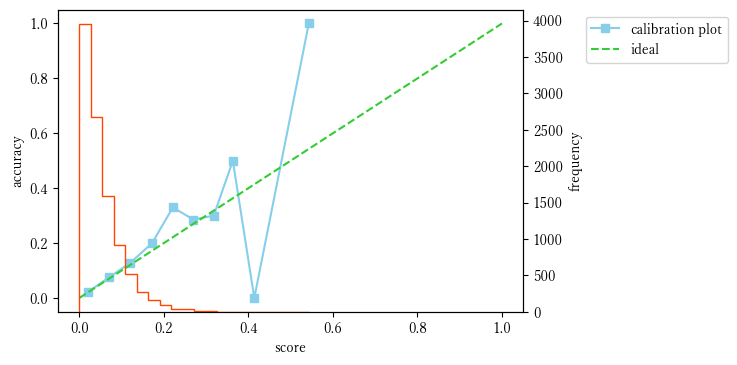

AUC 0.7575999365835007
対象カラム: 三連複_EV, 最大回収率: 4.8589, 閾値: 2.7, 対象数: 112, 対象率: 0.011


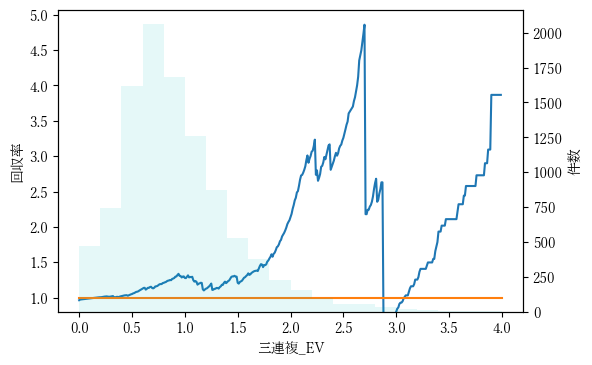

三連複 三連複_odds
----------------------------------------




In [579]:
target_col = '三連複'
odds_col = '三連複_odds'
print('-'*40)
print(target_col, odds_col)
df_use_c = df_use.copy()

df_use_c = df_use_c.merge(get_wk(target_col, 3), how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=300, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(df_use[target_col], y_pred_prob))

ev_col = target_col + '_EV'
# tmp_odds = '三連複_odds_tmp'
# df_use[tmp_odds] = np.where(df_use[odds_col]>300, 300, df_use[odds_col])
# df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, odds_col, target_col ,vmax=min(df_use[ev_col].max(), 4), step=0.01, over=True, plot_min=0.8)

print(target_col, odds_col)
print('-'*40)
print()
print()

In [448]:
df_use_c[[target_col]+X_cols].corr().style.background_gradient()

,三連複,score1,s_diff_12,s_diff_13,s_diff_23,s_diff_34,score1_ss,score2_ss,score3_ss,score4_ss,odds1,odds2,odds3,odds_p1,oddsp1_score,weather_int_1,weather_int_2,weather_int_3,condition_int_1,condition_int_2,label_1,label_2,race_class_prize_1勝クラス,race_class_prize_3勝クラス,race_class_prize_オープン,race_class_prize_未勝利
三連複,1.000000,0.066039,0.022502,0.049675,0.049140,0.101880,-0.013879,-0.017261,-0.044964,-0.109794,-0.066303,-0.064238,-0.070401,-0.090345,0.090397,-0.024939,0.027774,-0.004943,-0.005518,0.005871,0.055923,-0.058349,-0.037905,-0.027756,0.010701,0.037978
score1,0.066039,1.000000,0.599351,0.711826,0.324235,0.233653,0.450663,-0.070045,-0.236517,-0.277659,-0.219085,-0.067687,-0.000540,-0.241889,0.638257,-0.006202,0.002297,0.009950,-0.022071,0.014059,-0.015706,-0.005094,-0.133543,-0.019226,-0.084403,0.223602
s_diff_12,0.022502,0.599351,1.000000,0.786657,-0.104951,-0.058080,0.734290,-0.578108,-0.418958,-0.314297,-0.191321,0.080653,0.081399,-0.178426,0.336143,0.005766,-0.017680,0.028442,-0.001112,-0.003222,0.000043,-0.012266,-0.030060,-0.032987,-0.020087,0.096124
s_diff_13,0.049675,0.711826,0.786657,1.000000,0.531420,-0.090472,0.748485,-0.167012,-0.682828,-0.514313,-0.236120,-0.027908,0.113245,-0.256203,0.440806,-0.010017,-0.001367,0.028380,-0.017773,0.009940,0.002017,-0.020535,-0.058622,-0.048294,-0.033809,0.166509
s_diff_23,0.049140,0.324235,-0.104951,0.531420,1.000000,-0.066039,0.198138,0.524190,-0.525039,-0.397202,-0.117829,-0.155616,0.070727,-0.167871,0.248826,-0.024047,0.022056,0.006689,-0.027102,0.020432,0.003191,-0.016248,-0.053183,-0.032530,-0.026898,0.136318
s_diff_34,0.101880,0.233653,-0.058080,-0.090472,-0.066039,1.000000,-0.008069,0.202912,0.361394,-0.466559,-0.095627,-0.096630,-0.126447,-0.136051,0.189412,0.007564,-0.010281,0.006003,0.002660,-0.001563,0.006328,0.007587,-0.070451,-0.013352,-0.016959,0.140949
score1_ss,-0.013879,0.450663,0.734290,0.748485,0.198138,-0.008069,1.000000,0.037781,-0.205648,-0.198233,-0.180520,0.046971,0.127819,-0.047501,0.244574,0.006716,-0.022529,0.037825,-0.008260,0.006865,-0.008641,0.020461,-0.033558,-0.103450,-0.055895,0.246231
score2_ss,-0.017261,-0.070045,-0.578108,-0.167012,0.524190,0.202912,0.037781,1.000000,0.398489,0.200906,0.022996,-0.129809,-0.005907,0.124189,0.002765,-0.005793,0.004643,0.003235,-0.017335,0.019853,-0.016406,0.039065,-0.047110,-0.070257,-0.068045,0.228438
score3_ss,-0.044964,-0.236517,-0.418958,-0.682828,-0.525039,0.361394,-0.205648,0.398489,1.000000,0.624451,0.123379,0.016476,-0.110599,0.255476,-0.134819,0.020616,-0.019139,-0.005175,0.008139,-0.000206,-0.023989,0.054556,-0.018111,-0.035699,-0.063594,0.130067
score4_ss,-0.109794,-0.277659,-0.314297,-0.514313,-0.397202,-0.466559,-0.198233,0.200906,0.624451,1.000000,0.178280,0.082201,-0.009874,0.318820,-0.188706,0.010731,-0.007617,-0.008382,0.001830,0.002766,-0.032326,0.043761,0.016170,-0.022810,-0.062051,0.046415


In [466]:
df_ac.三連複_odds.max()

5580.6

In [469]:
df_ac.三連複_odds.mean() + (df_ac.三連複_odds.std() * 3)

510.7175278100499

In [425]:
df_ac.三連複_odds.mean()

60.77373835403726

In [426]:
df_ac.三連複_odds.median()

24.0

In [427]:
df_ac.query('三連複==1').三連複_odds.sum() / df_ac.shape[0]

0.9462890438437291

<AxesSubplot:>

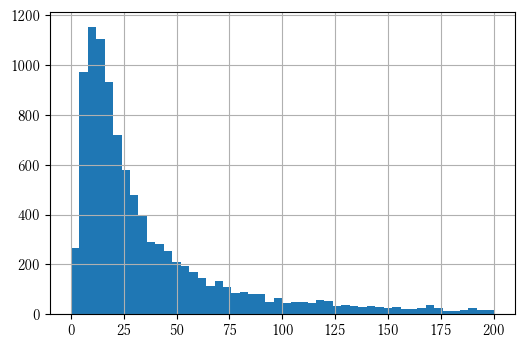

In [428]:
df_ac.三連複_odds.hist(bins=50, range=(0,200))

In [566]:
df_th.loc[ev_col] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0]
]

In [567]:
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate
三連複_EV,0.16,0.959467,0.79,0.532076,1.78,0.068915


In [451]:
df_use[pred_col].max()

0.5276840838972714

対象カラム: 三連複_pred, 最大回収率: 1.8, 閾値: 0.365, 対象数: 4, 対象率: 0.0


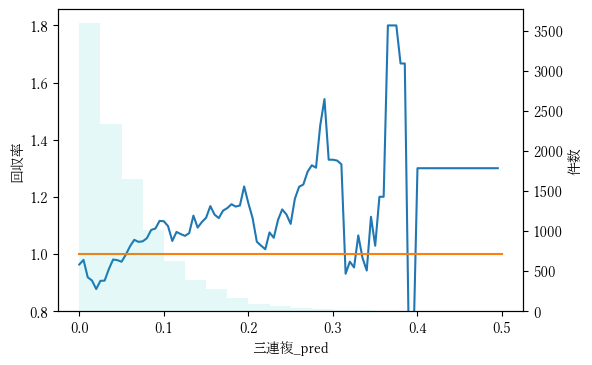

In [471]:
# df_use['pred_50'] = df_use.pred * 50

df_ret, max_th = get_return(df_use, pred_col, odds_col, target_col ,vmax=0.5, step=0.005, over=True, plot_min=0.8)

<AxesSubplot:>

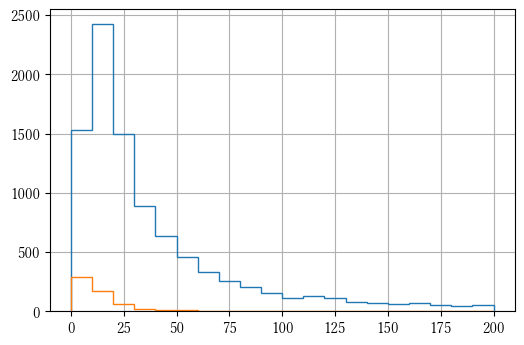

In [478]:
df_use.query('三連複==0').三連複_odds.hist(bins=20, histtype='step', range=(0,200))
df_use.query('三連複==1').三連複_odds.hist(bins=20, histtype='step', range=(0,200))

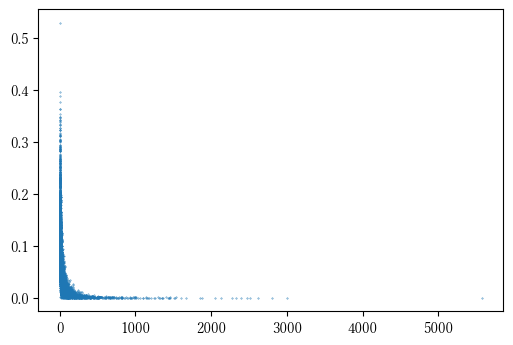

In [476]:
plt.scatter(df_use.三連複_odds, df_use.三連複_pred, s=0.1)x

In [189]:
# EVと生スコアの複合型がよいかも

### 三連複2

In [580]:
X_cols = [
 'score1',
 'score2',
 'score3',
 'score4',
 's_diff_12',
#  's_diff_13',
 's_diff_23',
 's_diff_34',
 'score1_ss',
 'score2_ss',
 'score3_ss',
 'score4_ss',
 'odds1',
 'odds2',
 'odds3',
#  '複勝_odds',
#  '馬連_odds',
#  '馬単_odds',
#  '馬単_2_odds',
#  'ワイド_odds',
#  '三連複_odds',
#  '三連単_odds',
 'odds_p1',
 'oddsp1_score',
#  'odds_p1_s_diff1',
#  'odds_p1_s_diff2',
#  'odds_p3_s_diff3',
 'weather_int_1',
 'weather_int_2',
 'weather_int_3',
#  'condition_int_1',
 'condition_int_2',
 'condition_int_3',
'label_0', 
'label_1',
'label_2',
# 'label_3', 
# 'label_4',
'race_class_prize_1勝クラス',
 'race_class_prize_2勝クラス',
 'race_class_prize_3勝クラス',
 'race_class_prize_G1',
 'race_class_prize_G2',
 'race_class_prize_G3',
 'race_class_prize_オープン',
#  'race_class_prize_未勝利'
]

----------------------------------------
三連複 三連複_odds


,0
score1,0.283630
score2,0.142465
score3,-0.064306
score4,-0.422776
s_diff_12,0.141165
s_diff_23,0.206771
s_diff_34,0.358470
score1_ss,-0.323511
score2_ss,-0.096837
score3_ss,0.015989


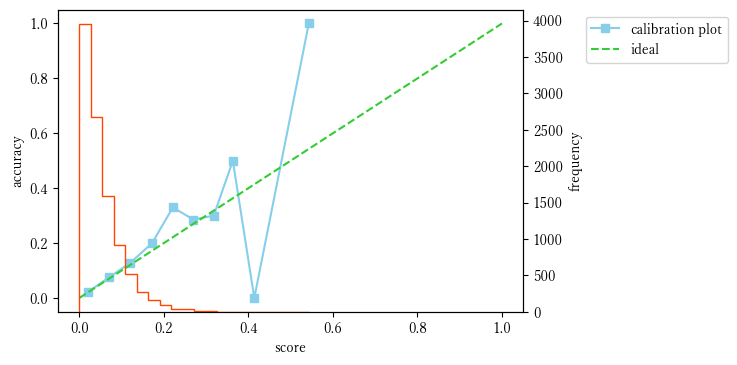

AUC 0.7575999365835007
対象カラム: 三連複_EV, 最大回収率: 4.8589, 閾値: 2.7, 対象数: 112, 対象率: 0.011


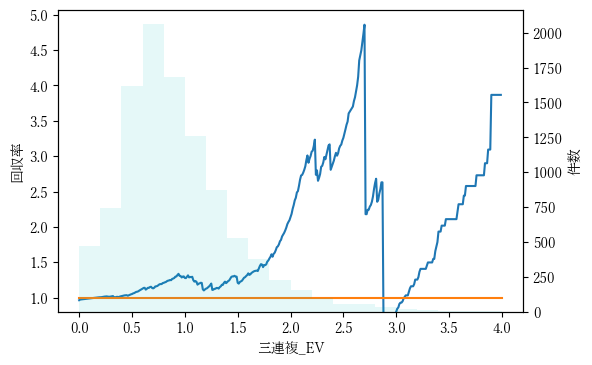

三連複 三連複_odds
----------------------------------------




In [579]:
target_col = '三連複'
odds_col = '三連複_odds'
print('-'*40)
print(target_col, odds_col)
df_use_c = df_use.copy()

df_use_c = df_use_c.merge(get_wk(target_col, 3), how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

# s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
df_train, df_test = train_test_split(df_use_c, stratify=df_use_c[target_col], random_state=0)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=300, class_weight='balanced')
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
# s_rate = 1
s_rate = y_train.sum() / len(y_train)
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(df_use[target_col], y_pred_prob))

ev_col = target_col + '_EV'
# tmp_odds = '三連複_odds_tmp'
# df_use[tmp_odds] = np.where(df_use[odds_col]>300, 300, df_use[odds_col])
# df_use[ev_col] = df_use[pred_col] * df_use[tmp_odds]
# df_use[ev_col] = np.where(df_use[pred_col] < 0.06, 0, df_use[pred_col]) * df_use[odds_col]
df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, odds_col, target_col ,vmax=min(df_use[ev_col].max(), 4), step=0.01, over=True, plot_min=0.8)

print(target_col, odds_col)
print('-'*40)
print()
print()

### 三連単

In [198]:
X_cols = [
 'score1',
 'score2',
 'score3',
 'score4',
 's_diff_12',
 's_diff_13',
 's_diff_23',
 's_diff_34',
#  'score1_ss',
#  'score2_ss',
#  'score3_ss',
#  'score4_ss',
 'odds1',
 'odds2',
 'odds3',
 '複勝_odds',
#  '馬連_odds',
#  '馬単_odds',
 '馬単_2_odds',
 'ワイド_odds',
#  '三連複_odds',
#  '三連単_odds',
 'odds_p1',
#  'oddsp1_score',
#  'odds_p1_s_diff1',
 'odds_p1_s_diff2',
 'odds_p3_s_diff3',
 'weather_int_1',
 'weather_int_2',
 'weather_int_3',
 'condition_int_1',
 'condition_int_2',
 'condition_int_3',
    'label_0', 
'label_1',
'label_2',
# 'label_3', 
# 'label_4',
]

----------------------------------------
三連単 三連単_odds


三連単,0,1,All
種類,,,
test,81,1,82
train,117,117,234
All,198,118,316


,0
score1,0.652603
score2,1.023452
score3,-0.784778
score4,-1.354661
s_diff_12,-0.370849
s_diff_13,1.437381
s_diff_23,1.808230
s_diff_34,0.569883
odds1,-0.653296
odds2,-0.057432


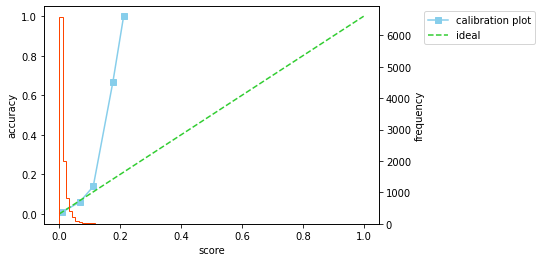

AUC 0.7867431628418577
対象カラム: 三連単_EV, 最大回収率: 4.227, 閾値: 4.99, 対象数: 211, 対象率: 0.021


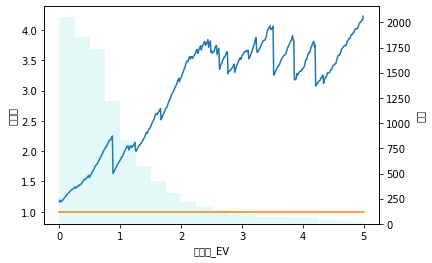

三連単 三連単_odds
----------------------------------------




In [199]:
target_col = '三連単'
odds_col = '三連単_odds'
print('-'*40)
print(target_col, odds_col)
df_use_c = df_use.copy()

df_use_c = df_use_c.merge(get_wk(target_col, 3), how='left', left_on='race_date', right_index=True)
df_use_c = pd.get_dummies(df_use_c, columns=['label'])

s_rate, df_train, df_test = get_balanced_data(df_use_c, target_col)
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[target_col]
y_test = df_test[target_col]

clf = LogisticRegression(random_state=0, C=100)
clf.fit(X_train, y_train)
display(pd.Series(clf.coef_[0], X_train.columns).to_frame())

y_pred_prob = clf.predict_proba(df_use_c[X_cols])[:, 1]
s_rate = 1
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)
pred_col = target_col + '_pred'
df_use[pred_col] = prob2
output_model(clf, target_col, df_use[target_col], prob2, s_rate, X_cols)
print('AUC', roc_auc_score(df_use[target_col], y_pred_prob))

ev_col = target_col + '_EV'
df_use[ev_col] = df_use[pred_col] * df_use[odds_col]
df_ret, max_th = get_return(df_use, ev_col, odds_col, target_col ,vmax=min(df_use[ev_col].max(), 5), step=0.01, over=True, plot_min=0.8)

print(target_col, odds_col)
print('-'*40)
print()
print()

In [200]:
df_ret

,対象数,回収率,対象率
0.00,10288.0,1.166,1.000000
0.01,10064.0,1.192,0.978227
0.02,10001.0,1.164,0.972103
0.03,9956.0,1.169,0.967729
0.04,9891.0,1.177,0.961411
...,...,...,...
4.95,216.0,4.129,0.020995
4.96,215.0,4.148,0.020898
4.97,214.0,4.167,0.020801
4.98,214.0,4.167,0.020801


In [201]:
df_use.query('三連単==1').三連単_odds.sum() / df_use.shape[0]

1.1656292962674961

In [202]:
df_th.loc[ev_col] = [
    df_ret.query('回収率>=1').index[0],
    df_ret.query('回収率>=1').対象率.values[0],
    df_ret.query('回収率>=1.2').index[0],
    df_ret.query('回収率>=1.2').対象率.values[0],
    df_ret.query('回収率>=1.5').index[0],
    df_ret.query('回収率>=1.5').対象率.values[0]
]

# 閾値以上の馬券とは

In [306]:
df_th

,ret100_th,ret100_rate,ret120_th,ret120_rate,ret150_th,ret150_rate
三連複_EV,0.14,0.97152,0.75,0.593896,1.05,0.359448


In [568]:
col_dict = {}
for idx, row in df_th.iterrows():
    name = idx[:-3]
    tmp_dict = {}
    for th in ['100', '120', '150']:
        th_col = f'ret{th}_th'
        buy_col = f'{name}_{th}_buy'
        tmp_dict[th] = buy_col
        
        df_use[buy_col] = 0
        df_use.loc[df_use[idx]>=row[th_col], buy_col] = 1
    col_dict[name] = tmp_dict

In [308]:
df_use[[v['120'] for v in col_dict.values()]].sum(axis=1).value_counts().sort_index()

0    4178
1    6110
dtype: int64

In [309]:
df_use[[v['120'] for v in col_dict.values()]].sum(axis=1).value_counts().sort_index() / df_use.shape[0]

0    0.406104
1    0.593896
dtype: float64

In [310]:
col_dict

{'三連複': {'100': '三連複_100_buy', '120': '三連複_120_buy', '150': '三連複_150_buy'}}

In [311]:
plt.rcParams['font.family'] = 'Yu mincho'
plt.rcParams['figure.dpi'] = 100

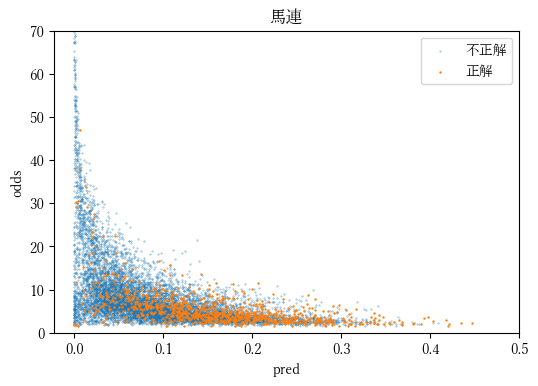

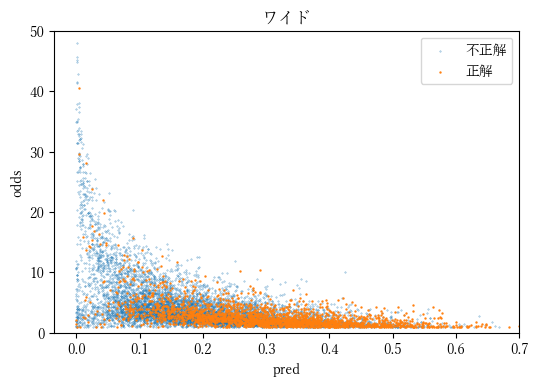

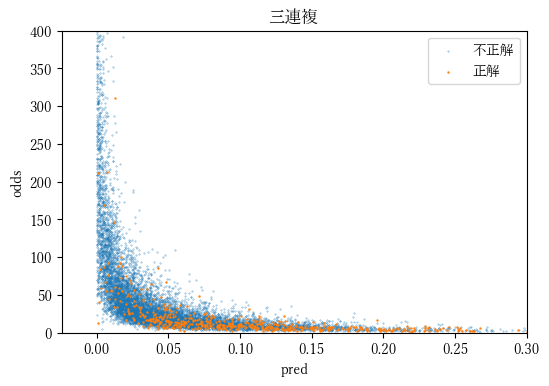

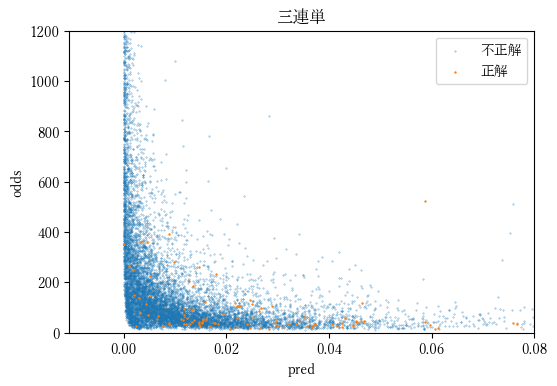

<Figure size 600x400 with 0 Axes>

In [257]:
ylim = {'複勝':15, '馬連':70, 'ワイド': 50, '三連複': 400, '三連単': 1200}
xlim = {'複勝':1, '馬連':0.5, 'ワイド': 0.7, '三連複': 0.30, '三連単': 0.08}
for col in col_dict.keys():
    plt.scatter(
        df_use.loc[df_use[col]==0, f'{col}_pred'],
        df_use.loc[df_use[col]==0, f'{col}_odds'],
        s=0.1,
        alpha=0.7
    )
    plt.scatter(
        df_use.loc[df_use[col]==1, f'{col}_pred'],
        df_use.loc[df_use[col]==1, f'{col}_odds'],
        s=0.5,
#         alpha=0.7
    )

#         plt.xlim(0, min(df_use[f'{col}_pred'].max(), 1))
        
    plt.ylim(0, min(df_use[f'{col}_odds'].max(), ylim[col]))
    plt.xlim(right=xlim[col])
    plt.title(col)
    plt.xlabel('pred')
    plt.ylabel('odds')
    plt.legend(['不正解', '正解'])
    plt.show()
    plt.clf()

In [258]:
pd.options.display.max_columns = 100

In [259]:
df_use.loc[(df_use.三連単_odds>500) &(df_use.三連単==1)]

,単勝,複勝,馬連,馬単,馬単_2,ワイド,三連複,三連単,score1,score2,score3,score4,s_diff_12,s_diff_13,s_diff_23,s_diff_34,score1_ss,score2_ss,score3_ss,score4_ss,odds1,odds2,odds3,複勝_odds,三連複_key,三連複_odds,馬連_odds,馬単_odds,馬単_2_odds,ワイド_odds,三連単_odds,odds_p1,oddsp1_score,odds_p1_s_diff1,odds_p1_s_diff2,odds_p3_s_diff3,race_date,weather_int_1,weather_int_2,weather_int_3,condition_int_1,condition_int_2,condition_int_3,複勝_pred,複勝_EV,馬連_pred,馬連_EV,ワイド_pred,ワイド_EV,三連複_pred,三連複_EV,三連単_pred,三連単_EV,馬連_100_buy,馬連_120_buy,馬連_150_buy,ワイド_100_buy,ワイド_120_buy,ワイド_150_buy,三連複_100_buy,三連複_120_buy,三連複_150_buy,三連単_100_buy,三連単_120_buy,三連単_150_buy
race_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
201406040809,1,1,1,1,0,1,1,1,0.358990,0.341003,0.324196,0.318078,0.017987,0.034794,0.016807,0.006119,1.571202,1.414373,1.267826,1.214476,4.5,30.5,30.8,1.7,201406040809060710,766.6,6.75,109.800,110.880,3.15,2536.3800,3.2,0.318078,-0.040913,-0.022926,-0.006119,52,1,0,0,1,0,0,0.480365,0.816620,0.008322,0.056172,0.028683,0.090352,0.001675,1.284291,0.000343,0.870701,0,0,0,0,0,0,1,1,1,1,1,1
201804020201,1,1,1,1,0,1,1,1,0.552419,0.319040,0.242881,0.100640,0.233379,0.309538,0.076159,0.142241,2.581432,1.132116,0.659158,-0.224180,1.1,8.6,92.3,1.0,201804020201020708,13.5,1.65,7.568,81.224,1.00,523.8948,1.1,0.552419,0.000000,0.233379,0.309538,30,1,0,0,1,0,0,0.859718,0.859718,0.307084,0.506688,0.512022,0.512022,0.001001,0.013507,0.058639,30.720869,0,0,0,0,0,0,0,0,0,1,1,1


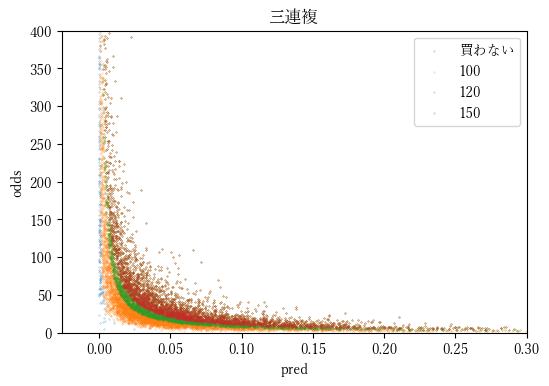

<Figure size 600x400 with 0 Axes>

In [314]:
ylim = {'複勝':15, '馬連':70, 'ワイド': 40, '三連複': 400, '三連単': 1200}
xlim = {'複勝':1, '馬連':0.5, 'ワイド': 0.7, '三連複': 0.30, '三連単': 0.08}
for name,d in col_dict.items():
    for k, col in d.items():
        if '100' in col:
            plt.scatter(
                df_use.loc[df_use[col]==0, f'{name}_pred'],
                df_use.loc[df_use[col]==0, f'{name}_odds'],
                s=0.05,
                alpha=0.7
            )
        plt.scatter(
            df_use.loc[df_use[col]==1, f'{name}_pred'],
            df_use.loc[df_use[col]==1, f'{name}_odds'],
            s=0.05,
            alpha=0.7
        )

#         plt.xlim(0, min(df_use[f'{name}_pred'].max(), 1))
        
    plt.ylim(0, min(df_use[f'{name}_odds'].max(), ylim[name]))
    plt.xlim(right=xlim[name])
    plt.title(name)
    plt.xlabel('pred')
    plt.ylabel('odds')
    plt.legend(['買わない', '100', '120', '150'])
    plt.show()
    plt.clf()

In [261]:
pd.options.display.max_columns = 50

In [262]:
df_use[sum([list(v.values()) for v in col_dict.values()], [])].head(50).style.background_gradient()

,馬連_100_buy,馬連_120_buy,馬連_150_buy,ワイド_100_buy,ワイド_120_buy,ワイド_150_buy,三連複_100_buy,三連複_120_buy,三連複_150_buy,三連単_100_buy,三連単_120_buy,三連単_150_buy
race_id,,,,,,,,,,,,
201201010101,1,0,0,1,0,0,1,1,0,1,1,1
201201010104,0,0,0,0,0,0,1,1,1,1,1,1
201201010108,0,0,0,0,0,0,1,1,0,1,1,1
201201010110,0,0,0,1,0,0,1,1,1,1,1,1
201201010112,0,0,0,0,0,0,1,1,0,1,1,1
201201010201,0,0,0,0,0,0,1,1,0,1,1,1
201201010203,0,0,0,0,0,0,1,1,1,1,1,1
201201010208,1,1,0,1,0,0,1,0,0,1,1,0
201201010210,0,0,0,0,0,0,1,1,0,1,1,1


In [538]:
df_tmp = df_use.loc[df_use.index.isin(df_info.loc[df_info.race_date.dt.year==2018].index)]

In [539]:
df_tmp.shape

(1355, 56)

In [540]:
def get_return120(v):
    col = '三連複'
    v = v.query(col+'_120_buy==1')
    return v.query(col+'==1')[col+'_odds'].sum() / v.shape[0]

def get_return150(v):
    col = '三連複'
    v = v.query(col+'_150_buy==1')
    return v.query(col+'==1')[col+'_odds'].sum() / v.shape[0]

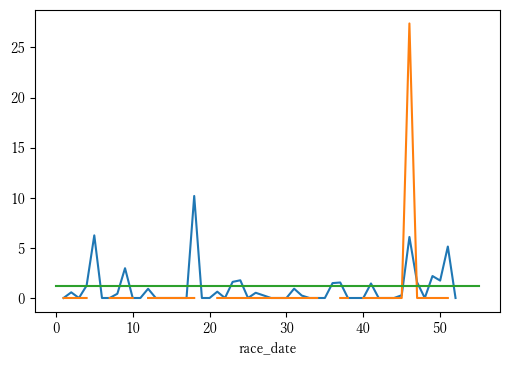

In [541]:
a = df_tmp.groupby('race_date').apply(get_return120)
a.plot()
b = df_tmp.groupby('race_date').apply(get_return150)
b.plot()
plt.plot([0, 55], [1.2, 1.2])

In [542]:
df_tmp.query('(三連複==1) and (三連複_120_buy==1)').三連複_odds.sum() / df_tmp.query('(三連複_120_buy==1)').shape[0]

0.9149275362318839

In [543]:
df_tmp.query('(三連複_120_buy==1)').shape[0]

690

In [544]:
df_tmp.query('(三連複==1) and (三連複_150_buy==1)').三連複_odds.sum() / df_tmp.query('(三連複_150_buy==1)').shape[0]

0.4455284552845528

In [545]:
df_tmp.query('(三連複_150_buy==1)').shape[0]

123

In [546]:
df_info.race_date.dt.year.value_counts().sort_index()

2010     175
2011     639
2012    3309
2013    3312
2014    3206
2015    3325
2016    3326
2017    3329
2018    3262
2019    3242
Name: race_date, dtype: int64

In [575]:
income_dict = {}
for y in range(2012, 2020):
    df_tmp = df_use.loc[df_use.index.isin(df_info.loc[df_info.race_date.dt.year==y].index)]
#     df_tmp = df_tmp.merge(
#         df_info.race_date.dt.week.to_frame(),
#         how='left',
#         left_index=True,
#         right_index=True
#     )
    tmp = pd.concat([
        df_tmp.query('(三連複_120_buy==1)').race_date.value_counts(),
        df_tmp.query('(三連複==1) and (三連複_120_buy==1)').groupby('race_date').三連複_odds.sum()
    ], axis=1)
    tmp.columns = ['buy', 'income']
    tmp.sort_index(inplace=True)
    tmp.income.fillna(0, inplace=True)

    tmp['in_diff'] = tmp.income - tmp.buy
    tmp['diff_cumsum'] = tmp.in_diff.cumsum()
    tmp['buy_cumsum'] = tmp.buy.cumsum()
    income_dict[y] = tmp

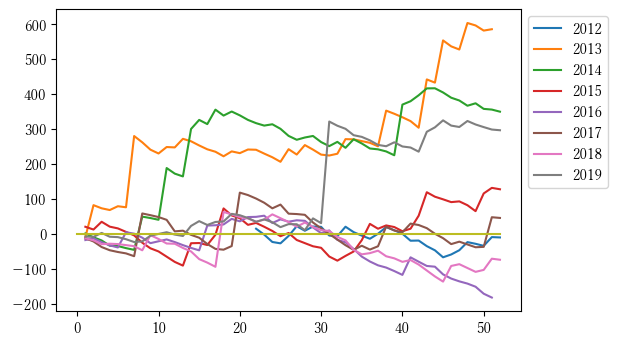

,buy_sum,diff_min,total_in,total_in_rate
2012,436.0,-67.4,-10.5,-0.024083
2013,656.0,-10.0,586.0,0.893293
2014,693.0,-46.1,349.8,0.504762
2015,789.0,-91.2,127.5,0.161597
2016,780.0,-182.7,-182.7,-0.234231
2017,724.0,-64.2,45.4,0.062707
2018,703.0,-137.0,-74.4,-0.105832
2019,693.0,-23.6,296.6,0.427994


In [576]:
df_y = pd.DataFrame(columns=['buy_sum', 'diff_min', 'total_in', 'total_in_rate'])
for k,v in income_dict.items():
    df_y.loc[k] = [
        v.buy.sum(),
        v.diff_cumsum.min(),
        v.tail(1).diff_cumsum.values[0],
        (v.tail(1).diff_cumsum / v.tail(1).buy_cumsum).values[0]
    ]
    v.diff_cumsum.plot()
plt.legend(income_dict.keys(), bbox_to_anchor=(1,1))
plt.plot([0, 52], [0, 0])
plt.show()
display(df_y)

In [577]:
income_dict[2016]

,buy,income,in_diff,diff_cumsum,buy_cumsum
1,18,0.0,-18.0,-18.0,18
2,15,19.9,4.9,-13.1,33
3,11,0.0,-11.0,-24.1,44
4,19,9.9,-9.1,-33.2,63
5,6,0.0,-6.0,-39.2,69
6,12,55.5,43.5,4.3,81
7,4,0.0,-4.0,0.3,85
8,20,8.5,-11.5,-11.2,105
9,21,5.3,-15.7,-26.9,126
10,14,19.4,5.4,-21.5,140


In [286]:
df_use.query('三連複==1').sort_values('三連複_odds', ascending=False)[acc_cols+['score1', 'score2', 'score3','score4', 'odds1', 'odds2', 'odds3', '三連複_pred', '三連複_odds', '三連複_150_buy']]

,単勝,複勝,馬連,馬単,馬単_2,ワイド,三連複,三連単,score1,score2,score3,score4,odds1,odds2,odds3,三連複_pred,三連複_odds,三連複_150_buy
race_id,,,,,,,,,,,,,,,,,,
201406040809,1,1,1,1,0,1,1,1,0.358990,0.341003,0.324196,0.318078,4.5,30.5,30.8,0.001675,766.6,1
201910020410,0,1,0,0,0,1,1,0,0.283370,0.261864,0.211379,0.206451,9.1,14.3,22.1,0.013090,311.0,1
201305010807,1,1,1,1,0,1,1,1,0.450259,0.377424,0.339731,0.296803,5.3,20.7,5.5,0.007074,213.1,1
201305021109,1,1,0,0,1,1,1,0,0.367949,0.313322,0.305918,0.277695,22.7,11.1,5.1,0.000830,211.6,0
201905040311,1,1,0,0,1,1,1,0,0.417376,0.349401,0.313391,0.240151,20.7,5.3,12.3,0.004938,169.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201807030801,1,1,0,0,1,1,1,0,0.541217,0.478195,0.368106,0.254093,1.5,3.0,7.8,0.188709,1.7,0
201702020101,0,1,0,0,0,1,1,0,0.395151,0.386032,0.274902,0.100810,2.6,1.5,8.7,0.304512,1.7,0
201801010101,1,1,1,1,0,1,1,1,0.538643,0.336356,0.320369,0.106104,1.1,7.6,8.3,0.299863,1.6,0


In [275]:
income_dict[2014]

,buy,income,in_diff,diff_cumsum,buy_cumsum
2,3,0.0,-3.0,-3.0,3
3,1,0.0,-1.0,-4.0,4
4,14,29.0,15.0,11.0,18
5,1,0.0,-1.0,10.0,19
8,1,0.0,-1.0,9.0,20
9,12,34.7,22.7,31.7,32
11,3,0.0,-3.0,28.7,35
12,9,0.0,-9.0,19.7,44
13,12,0.0,-12.0,7.7,56
14,3,0.0,-3.0,4.7,59


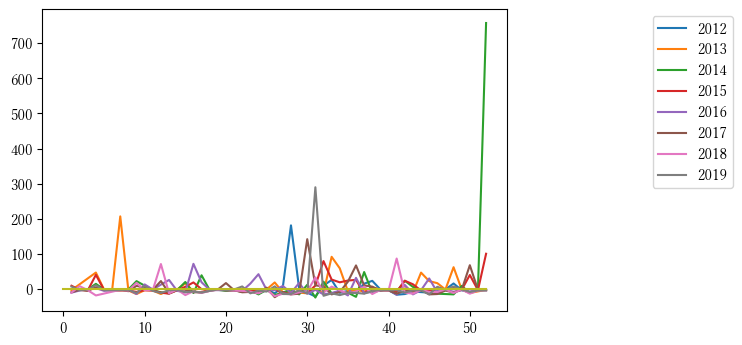

In [276]:
for k,v in income_dict.items():
    v.in_diff.plot()
plt.legend(income_dict.keys(), bbox_to_anchor=(1.5,1))
plt.plot([0, 52], [0, 0])
plt.show()

In [277]:
in_diff = pd.concat([v[['in_diff']].rename(columns={'in_diff':k}) for k,v in income_dict.items()], axis=1)
buy = pd.concat([v[['buy']].rename(columns={'buy':k}) for k,v in income_dict.items()], axis=1)

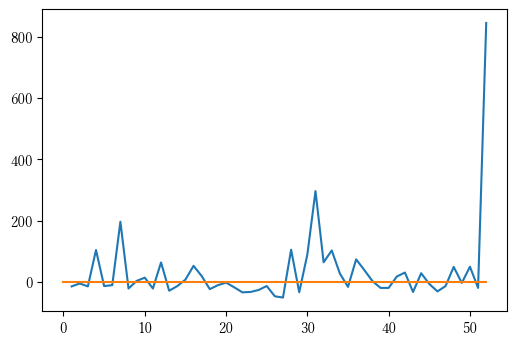

In [278]:
in_diff.sum(axis=1).plot()
plt.plot([0, 52], [0, 0])

In [279]:
in_diff['total'] = in_diff.sum(axis=1)
buy['total'] = buy.sum(axis=1)

<AxesSubplot:>

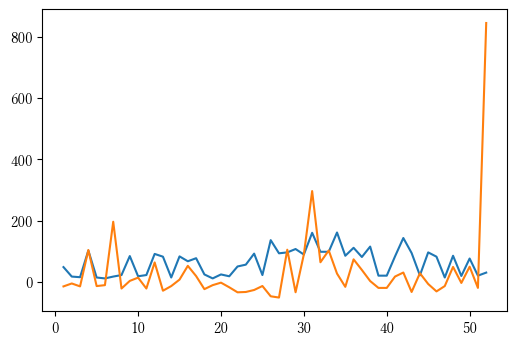

In [280]:
buy.total.plot()
in_diff.total.plot()

# 2020

In [1003]:
import pathlib
resource_path = pathlib.Path('../../../resource')
file_score = resource_path / 'common/model/WinHorse/features/wh_score_2020.csv'

df_2020 = pd.read_csv(file_score, index_col=0)
df_2020.shape

df_result = pd.read_csv(resource_path/'common/race_result_transaction.csv')
df_result.shape

df_2020 = df_2020.merge(df_result[['arrival', 'race_id', 'horse_id','odds']], how='left', on=['race_id', 'horse_id'])
df_2020.shape

df_2020['pred_rank'] = df_2020.groupby('race_id').pred.rank(ascending=False, method='min')

In [1004]:
df_2020

,race_id,horse_id,pred,arrival,odds,pred_rank
0,201910021212,40246,0.140604,15,17.5,9.0
1,201910021212,9733,0.057217,16,110.3,14.0
2,201910021212,10370,0.089896,3,21.9,11.0
3,201910021212,9024,0.057280,12,120.3,13.0
4,201910021212,42255,0.048567,8,36.9,16.0
...,...,...,...,...,...,...
16954,202005050908,48856,0.064735,9,543.5,10.0
16955,202009050902,49992,0.137741,15,62.1,13.0
16956,202005050911,35743,0.267957,6,5.2,3.0
16957,202005050912,45973,0.630415,2,2.8,1.0


# ----------------------

# 以下削除

In [10]:
df_ac = pd.DataFrame(index=df_pred.race_id.unique())
df_ac.index.name = 'race_id'
df_ac = df_ac.merge(
    df_pred.query('pred_rank==1')[['race_id', 'odds', 'odds_rank']].drop_duplicates('race_id').set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

df_ac['acc_flg'] = 0
df_ac.loc[df_ac.index.isin(accuracy_id), 'acc_flg'] = 1
tmp = pd.pivot_table(
    df_pred.query('pred_rank <=2'),
    values='pred_prob',
    index='race_id',
    columns='pred_rank'
)
tmp.columns = ['score1', 'score2']
df_ac = df_ac.merge(tmp, how='left', left_index=True, right_index=True)
df_ac['s_diff'] = df_ac.score1 - df_ac.score2

df_ac = df_ac.merge(df_info, how='left', left_index=True, right_index=True)

df_ac['EV'] = df_ac.odds * df_ac.score1
df_ac['EV_diff'] = df_ac.EV * df_ac.s_diff
df_ac['s_diff_rate'] = df_ac.s_diff * df_ac.score1

In [307]:
df_ac.acc_flg.value_counts()

0    7973
1    2496
Name: acc_flg, dtype: int64

In [13]:
df_ac

,odds,odds_rank,acc_flg,score1,score2,s_diff,condition_int,weather_int,EV,EV_diff,s_diff_rate,odds_1,odds1_score
race_id,,,,,,,,,,,,,
201201010101,5.9,2.0,0,0.366473,0.329453,0.037019,1,1,2.162189,0.080043,0.013567,1.7,0.304653
201201010104,3.7,2.0,1,0.483205,0.399544,0.083661,1,1,1.787858,0.149574,0.040425,2.7,0.399544
201201010108,2.7,1.0,0,0.495654,0.350361,0.145293,1,1,1.338265,0.194440,0.072015,2.7,0.495654
201201010110,3.7,2.0,0,0.309313,0.268529,0.040784,1,1,1.144460,0.046676,0.012615,2.4,0.141689
201201010112,2.2,1.0,0,0.503848,0.285949,0.217899,1,1,1.108466,0.241534,0.109788,2.2,0.503848
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021206,1.8,1.0,0,0.557048,0.427142,0.129906,3,3,1.002687,0.130255,0.072364,1.8,0.557048
201910021208,8.1,3.0,0,0.395746,0.331567,0.064178,3,3,3.205542,0.205727,0.025398,2.3,0.267114
201910021209,4.2,2.0,0,0.386423,0.373529,0.012894,3,3,1.622976,0.020926,0.004982,3.6,0.283039


In [14]:
df_ac['odds_diff'] = df_ac.odds - df_ac.odds_1
df_ac['odds_score_diff'] = df_ac.score1 - df_ac.odds1_score

In [15]:
df_ac

,odds,odds_rank,acc_flg,score1,score2,s_diff,condition_int,weather_int,EV,EV_diff,s_diff_rate,odds_1,odds1_score,odds_diff,odds_score_diff
race_id,,,,,,,,,,,,,,,
201201010101,5.9,2.0,0,0.366473,0.329453,0.037019,1,1,2.162189,0.080043,0.013567,1.7,0.304653,4.2,0.061820
201201010104,3.7,2.0,1,0.483205,0.399544,0.083661,1,1,1.787858,0.149574,0.040425,2.7,0.399544,1.0,0.083661
201201010108,2.7,1.0,0,0.495654,0.350361,0.145293,1,1,1.338265,0.194440,0.072015,2.7,0.495654,0.0,0.000000
201201010110,3.7,2.0,0,0.309313,0.268529,0.040784,1,1,1.144460,0.046676,0.012615,2.4,0.141689,1.3,0.167625
201201010112,2.2,1.0,0,0.503848,0.285949,0.217899,1,1,1.108466,0.241534,0.109788,2.2,0.503848,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021206,1.8,1.0,0,0.557048,0.427142,0.129906,3,3,1.002687,0.130255,0.072364,1.8,0.557048,0.0,0.000000
201910021208,8.1,3.0,0,0.395746,0.331567,0.064178,3,3,3.205542,0.205727,0.025398,2.3,0.267114,5.8,0.128632
201910021209,4.2,2.0,0,0.386423,0.373529,0.012894,3,3,1.622976,0.020926,0.004982,3.6,0.283039,0.6,0.103384


In [16]:
df_ac['odds_first'] = 0
df_ac.loc[df_ac.index.isin(df_pred.query('(pred_rank==1) and (odds_rank==1)').race_id), 'odds_first'] = 1
df_ac.odds_first.value_counts()

0    5875
1    4594
Name: odds_first, dtype: int64

# 購入閾値検索

In [17]:
def get_return(df, col, vmax=1, step=0.01, over=True, plot_min=0.8):
    df_ret = pd.DataFrame(columns=['対象数', '回収率'])
    if over:
        op = '>'
    else:
        op = '<'
    max_ret = -10000
    max_th = -1
    max_len = -1
    for th in np.arange(0, vmax, step):
        th = round(th, 2)
        tmp = df.query(col + op + str(th))
        ret = round((tmp.query('acc_flg==1').odds.sum()/tmp.shape[0]), 3)
        if ret > max_ret:
            max_ret = ret
            max_th = th
            max_len = len(tmp)
        df_ret.loc[th] = [tmp.shape[0], ret]
    print(f'対象カラム: {col}, 最大回収率: {max_ret}, 閾値: {max_th}, 対象数: {max_len}, 対象率: {round(max_len/df.shape[0], 3)}')
    
    df_ret['対象率'] = df_ret.対象数 / df.shape[0]
    
#     plt.scatter(max_th, max_ret, s=100, c='none', edgecolors='blue')
    df_ret.回収率.plot()
    plt.plot([0,vmax], [1,1])
    plt.ylim(plot_min, )
    plt.ylabel('回収率')
    plt.xlabel(col)
    plt.twinx()
    df[col].hist(bins=20, alpha=.1, color='c', grid=False, range=(0, vmax))
    plt.ylabel('件数')
    plt.show()
    return df_ret, max_th

対象カラム: EV, 最大回収率: 0.848, 閾値: 2.4, 対象数: 7414, 対象率: 0.708


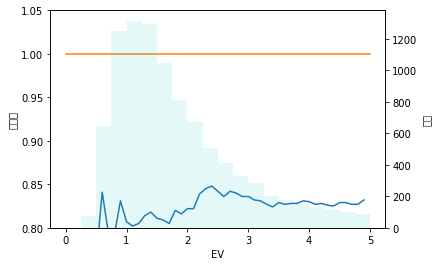

In [310]:
df_ret, max_th = get_return(df_ac, 'EV', 5, 0.1, over=False)

対象カラム: EV_diff, 最大回収率: 0.858, 閾値: 0.05, 対象数: 2861, 対象率: 0.273


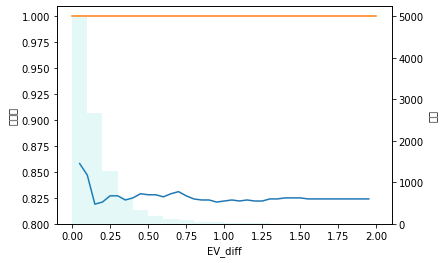

In [311]:
df_ret, max_th = get_return(df_ac, 'EV_diff', 2, 0.05, over=False)

対象カラム: odds, 最大回収率: 0.963, 閾値: 1.11, 対象数: 32, 対象率: 0.003


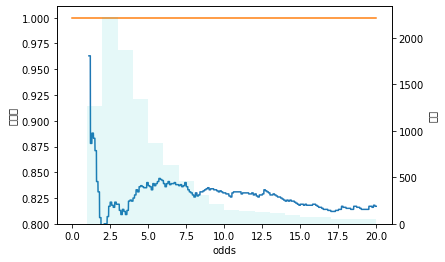

In [312]:
df_ret, max_th = get_return(df_ac, 'odds', 10, 0.01, over=False)

対象カラム: score1, 最大回収率: 1.296, 閾値: 0.66, 対象数: 23, 対象率: 0.002


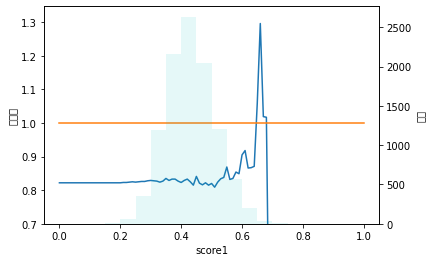

In [313]:
df_ret, max_th = get_return(df_ac, 'score1', 1, 0.01, over=True, plot_min=0.7)

対象カラム: s_diff, 最大回収率: 0.856, 閾値: 0.4, 対象数: 9, 対象率: 0.001


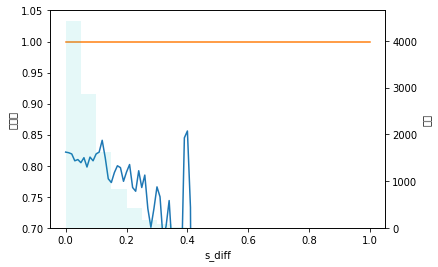

In [314]:
df_ret, max_th = get_return(df_ac, 's_diff', 1, 0.01, over=True, plot_min=0.7)

対象カラム: s_diff_rate, 最大回収率: 0.963, 閾値: 0.26, 対象数: 8, 対象率: 0.001


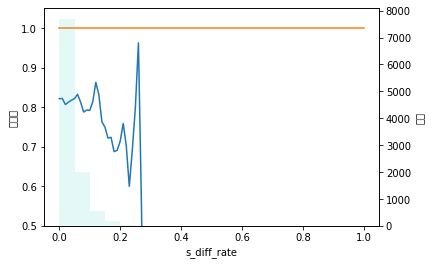

In [315]:
df_ret, max_th = get_return(df_ac, 's_diff_rate', 1, 0.01, over=True, plot_min=0.5)

# 購入モデル

## ライブラリ

In [18]:
import xgboost as xgb

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve,recall_score, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score

## 学習データ作成

In [20]:
# one-hot
df_use = pd.get_dummies(df_ac, columns=['weather_int', 'condition_int'], drop_first=True).dropna()

# target
df_use['target'] = df_use.acc_flg.copy()

In [21]:
df_use.head()

,odds,odds_rank,acc_flg,score1,score2,s_diff,EV,EV_diff,s_diff_rate,odds_1,odds1_score,odds_diff,odds_score_diff,odds_first,weather_int_2,weather_int_3,condition_int_2,condition_int_3,target
race_id,,,,,,,,,,,,,,,,,,,
201201010101,5.9,2.0,0,0.366473,0.329453,0.037019,2.162189,0.080043,0.013567,1.7,0.304653,4.2,0.061820,0,0,0,0,0,0
201201010104,3.7,2.0,1,0.483205,0.399544,0.083661,1.787858,0.149574,0.040425,2.7,0.399544,1.0,0.083661,0,0,0,0,0,1
201201010108,2.7,1.0,0,0.495654,0.350361,0.145293,1.338265,0.194440,0.072015,2.7,0.495654,0.0,0.000000,1,0,0,0,0,0
201201010110,3.7,2.0,0,0.309313,0.268529,0.040784,1.144460,0.046676,0.012615,2.4,0.141689,1.3,0.167625,0,0,0,0,0,0
201201010112,2.2,1.0,0,0.503848,0.285949,0.217899,1.108466,0.241534,0.109788,2.2,0.503848,0.0,0.000000,1,0,0,0,0,0


In [24]:
df_use['odds_score_diff_EV'] = df_use.odds_diff * df_use.odds_score_diff

df_use['odds1_EV'] = df_use.odds1_score * df_use.odds_1

df_use['prob1_odds1_div'] = df_use.score1 / df_use.odds1_score

df_use['odds_div'] = df_use.odds / df_use.odds_1

df_use['o1_EV_diff'] = df_use.odds1_EV * df_use.odds_score_diff

df_use['o1_EV_s_diff'] = df_use.odds1_EV * df_use.s_diff

In [26]:
df_train, df_test = train_test_split(df_use)
print(df_train.shape)
print(df_test.shape)

(7851, 25)
(2617, 25)


In [27]:
# 不均衡データ調整
target_size = (df_train.target==1).sum()

df_train_0 = df_train[df_train.target==0]
df_train_use = df_train_0.sample(target_size, random_state=0)
df_train_use = pd.concat([df_train_use, df_train[df_train.target==1]])

# X_train_use = X_train.loc[y_train_use.index]

In [28]:
df_train

,odds,odds_rank,acc_flg,score1,score2,s_diff,EV,EV_diff,s_diff_rate,odds_1,...,weather_int_3,condition_int_2,condition_int_3,target,odds_score_diff_EV,odds1_EV,prob1_odds1_div,odds_div,o1_EV_diff,o1_EV_s_diff
race_id,,,,,,,,,,,,,,,,,,,,,
201306040902,1.8,1.0,0,0.381934,0.270201,0.111733,0.687482,0.076815,0.042675,1.8,...,0,0,0,0,0.000000,0.687482,1.000000,1.000000,0.000000,0.076815
201609040407,6.3,3.0,0,0.530348,0.377825,0.152523,3.341192,0.509609,0.080890,2.7,...,1,0,1,0,1.241276,0.500983,2.858261,2.333333,0.172738,0.076411
201310021109,3.8,1.0,0,0.413263,0.386563,0.026700,1.570399,0.041929,0.011034,3.8,...,0,0,1,0,0.000000,1.570399,1.000000,1.000000,0.000000,0.041929
201503010510,4.6,2.0,0,0.411028,0.384753,0.026275,1.890728,0.049678,0.010800,3.3,...,0,0,0,0,0.034157,1.269685,1.068290,1.393939,0.033361,0.033361
201409050312,4.6,3.0,1,0.395640,0.374154,0.021486,1.819945,0.039103,0.008501,3.4,...,0,0,0,1,0.246447,0.646909,2.079391,1.352941,0.132858,0.013899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201807030807,11.9,3.0,0,0.432423,0.397534,0.034889,5.145833,0.179533,0.015087,1.3,...,0,0,0,0,0.962006,0.444168,1.265624,9.153846,0.040311,0.015497
201303020404,7.2,6.0,0,0.357981,0.351778,0.006203,2.577464,0.015988,0.002221,4.9,...,0,0,0,0,0.249808,1.221907,1.435549,1.469388,0.132714,0.007580
201706040402,3.6,1.0,0,0.424645,0.245690,0.178955,1.528722,0.273572,0.075992,3.6,...,1,1,0,0,0.000000,1.528722,1.000000,1.000000,0.000000,0.273572


In [29]:
X_cols = [col for col in df_train.columns if col not in {'acc_flg', 'target'}]
print(len(X_cols))

23


In [30]:
df_use[['target']+X_cols].corr().style.background_gradient()

,target,odds,odds_rank,score1,score2,s_diff,EV,EV_diff,s_diff_rate,odds_1,odds1_score,odds_diff,odds_score_diff,odds_first,weather_int_2,weather_int_3,condition_int_2,condition_int_3,odds_score_diff_EV,odds1_EV,prob1_odds1_div,odds_div,o1_EV_diff,o1_EV_s_diff
target,1.000000,-0.175319,-0.237389,0.103774,0.018511,0.101748,-0.178382,-0.095180,0.104902,-0.156753,0.206314,-0.159869,-0.174206,0.251105,-0.000436,0.019869,-0.001859,0.003705,-0.148089,0.028702,-0.126081,-0.148453,-0.163221,0.088482
odds,-0.175319,1.000000,0.798536,-0.196949,-0.040532,-0.187896,0.976103,0.426145,-0.184427,0.124637,-0.288225,0.994331,0.196910,-0.379195,0.002078,-0.016980,-0.014397,-0.019896,0.749244,-0.132309,0.135183,0.929965,0.190832,-0.190315
odds_rank,-0.237389,0.798536,1.000000,-0.250362,-0.042262,-0.247785,0.796191,0.391890,-0.245255,0.239135,-0.471108,0.779049,0.385814,-0.642552,0.001986,-0.022288,-0.009325,-0.018542,0.658872,-0.218005,0.261947,0.676905,0.408370,-0.285029
score1,0.103774,-0.196949,-0.250362,1.000000,0.566061,0.606594,-0.070662,0.319626,0.686474,-0.197288,0.636926,-0.177322,0.069709,0.205528,0.000313,0.017347,0.008527,0.021132,-0.067274,0.350346,-0.015504,-0.151888,0.145180,0.619402
score2,0.018511,-0.040532,-0.042262,0.566061,1.000000,-0.312010,0.051418,-0.111716,-0.196810,-0.051804,0.397903,-0.035292,-0.008889,-0.033288,0.007007,-0.005639,0.010135,0.010198,-0.030811,0.303203,-0.063519,-0.022267,0.087230,-0.156807
s_diff,0.101748,-0.187896,-0.247785,0.606594,-0.312010,1.000000,-0.131024,0.476106,0.980964,-0.177415,0.350322,-0.170328,0.088912,0.268974,-0.006397,0.025430,0.000053,0.014520,-0.047820,0.111366,0.043389,-0.153576,0.083196,0.865084
EV,-0.178382,0.976103,0.796191,-0.070662,0.051418,-0.131024,1.000000,0.538447,-0.120895,0.117008,-0.237736,0.971069,0.244464,-0.391251,-0.000016,-0.015666,-0.013911,-0.020757,0.785123,-0.092548,0.154012,0.908709,0.254724,-0.136020
EV_diff,-0.095180,0.426145,0.391890,0.319626,-0.111716,0.476106,0.538447,1.000000,0.464630,0.042755,-0.070067,0.424839,0.376374,-0.194335,0.004500,0.008127,-0.013801,-0.008728,0.602085,-0.017625,0.229430,0.410373,0.384468,0.372572
s_diff_rate,0.104902,-0.184427,-0.245255,0.686474,-0.196810,0.980964,-0.120895,0.464630,1.000000,-0.186213,0.415979,-0.165890,0.075355,0.265834,-0.003068,0.026210,0.002481,0.016210,-0.054722,0.154559,0.027078,-0.148937,0.081324,0.879762
odds_1,-0.156753,0.124637,0.239135,-0.197288,-0.051804,-0.177415,0.117008,0.042755,-0.186213,1.000000,-0.304312,0.018435,0.217424,-0.225673,0.010060,0.003378,0.005577,0.011931,0.050249,0.538237,0.176430,-0.097592,0.395408,0.035134


In [63]:
X_cols = [
    'odds',
#     'odds_rank',
    'score1',
    'score2',
    's_diff',
#     'EV',
    'EV_diff',
    's_diff_rate',
#     'odds_1',
    'odds1_score',
#     'odds_diff',
    'odds_score_diff',
    'odds_first',
    'weather_int_2',
    'weather_int_3',
    'condition_int_2',
    'condition_int_3',
    'odds_score_diff_EV',
#     'odds1_EV',
#     'prob1_odds1_div'
]

In [64]:
X_train = df_train_use[X_cols]
X_test = df_test[X_cols]
y_train = df_train_use['target']
y_test = df_test['target']

# X_train = df_use[X_cols]
# y_train = df_use['target']
# X_test = df_use[X_cols]
# y_test = df_use['target']

tmp = y_train.to_frame()
tmp['種類'] = 'train'
tmp2 = y_test.to_frame()
tmp2['種類'] = 'test'
tmp3 = pd.concat([tmp, tmp2])
df_sampling = pd.crosstab(tmp3.種類, tmp3.target, margins=True)
df_sampling

In [66]:
s_rate = y_test.sum() / len(y_test)
# s_rate = (y_test==1).sum() / y_test.shape[0]
s_rate

0.2399694306457776

## 学習

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=GradientBoostingRegressor(random_state=0), n_features_to_select=20, step=0.5)

# 特徴量削減の実行
rfe.fit(X, y.as_matrix().ravel())

# 削減実行後のデータを再構成
rfeData = pd.DataFrame(rfe.transform(X), columns=X.columns.values[rfe.support_])

# 削減後、特徴量は２０になっていることが確認できる
display(rfeData.shape)

In [67]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

pd.Series(clf.coef_[0], X_train.columns).to_frame()

LogisticRegression(random_state=0)

## 予測

In [69]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)

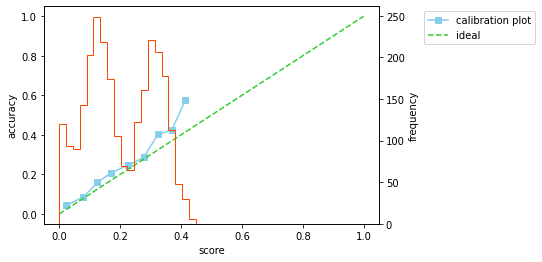

In [71]:
prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=prob2, n_bins=20)

fig, ax1 = plt.subplots()
ax1.plot(prob_pred, prob_true, marker='s', label='calibration plot', color='skyblue')
ax1.plot([0, 1], [0, 1], linestyle='--', label='ideal', color='limegreen')
ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
ax2 = ax1.twinx()
ax2.hist(prob2, bins=20, histtype='step', color='orangered')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('score')
ax2.set_ylabel('frequency')
# fig.savefig(log_path/'image/calibration_plot.png', bbox_inches='tight', pad_inche=.05)
plt.show()

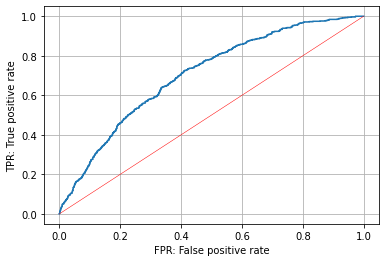

In [72]:
fpr_all, tpr_all, thresholds_all = roc_curve(y_test, y_pred_prob, drop_intermediate=False)
fig, ax = plt.subplots()
ax.plot(fpr_all, tpr_all, marker='o', markersize=.01)
ax.plot([0,1],[0,1], color='red', linewidth=.5)
ax.set_xlabel('FPR: False positive rate')
ax.set_ylabel('TPR: True positive rate')
ax.grid()
# fig.savefig(log_path/'image/roc_plot.png', bbox_inches='tight', pad_inche=.05)

In [73]:
roc_auc_score(y_test, y_pred_prob)

0.7034750042430822

## 閾値検索

In [74]:
df_test['pred'] = prob2

対象カラム: buy_pred, 最大回収率: 1.1, 閾値: 0.44, 対象数: 1, 対象率: 0.0


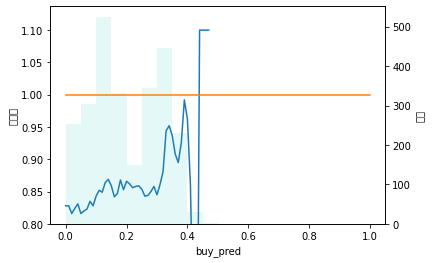

In [264]:
df_ret, max_th = get_return(df_test, 'buy_pred', 1, 0.01, over=True, plot_min=0.8)

In [76]:
df_ret.head()

,対象数,回収率,対象率
0.00,2617.0,0.819,1.000000
0.01,2557.0,0.821,0.977073
0.02,2508.0,0.822,0.958349
0.03,2467.0,0.823,0.942682
0.04,2423.0,0.814,0.925869


In [77]:
df_test['scores'] = df_test.score1 * df_test.pred

In [78]:
df_test['multi_EV'] = df_test.pred * df_test.odds

対象カラム: scores, 最大回収率: 1.6, 閾値: 0.29, 対象数: 2, 対象率: 0.001


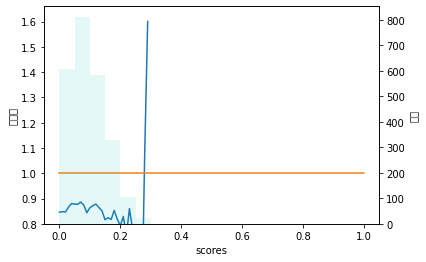

In [339]:
df_ret, max_th = get_return(df_test, 'scores', 1, 0.01, over=True, plot_min=0.8)

In [335]:
df_ret = pd.DataFrame(columns=[])
df_num = pd.DataFrame(columns=[])
over = True
col1 = 'buy_pred'
col2 = 's_diff'
df = df_use
if over:
    op = '>'
else:
    op = '<'
max_ret = -10000
max_th1 = -1
max_th2 = -1
max_len = -1
for th1 in np.arange(0, 0.5, 0.01):
    th1 = round(th1, 2)
    for th2 in np.arange(0, 0.5, 0.01):
        th2 = round(th2, 2)
        tmp = df.query(col1 + op + str(th1) + ' and ' + col2+op+str(th2))
        ret = round((tmp.query('acc_flg==1').odds.sum()/tmp.shape[0]), 3)
        if ret > max_ret:
            max_ret = ret
            max_th1 = th1
            max_th2 = th2
            max_len = len(tmp)
        df_ret.loc[th1, th2] = ret
        df_num.loc[th1, th2] = len(tmp)
print(f'最大回収率: {max_ret}, 閾値: {col1} {max_th1}: {col2} {max_th2}, 対象数: {max_len}, 対象率: {round(max_len/df.shape[0], 3)}')

# df_ret['対象率'] = df_ret.対象数 / df.shape[0]


最大回収率: 1.5, 閾値: buy_pred 0.43: s_diff 0.36, 対象数: 2, 対象率: 0.0


In [336]:
df_ret.style.background_gradient()

In [337]:
df_num

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49
0.00,10468.0,9425.0,8479.0,7610.0,6747.0,6038.0,5295.0,4668.0,4115.0,3628.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.01,10175.0,9190.0,8291.0,7464.0,6634.0,5944.0,5225.0,4615.0,4074.0,3595.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.02,10015.0,9049.0,8175.0,7363.0,6552.0,5870.0,5158.0,4556.0,4028.0,3559.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.03,9845.0,8902.0,8054.0,7262.0,6468.0,5795.0,5093.0,4501.0,3986.0,3525.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.04,9678.0,8757.0,7940.0,7162.0,6387.0,5724.0,5033.0,4448.0,3941.0,3491.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.05,9493.0,8605.0,7811.0,7054.0,6297.0,5651.0,4980.0,4405.0,3907.0,3464.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.06,9328.0,8473.0,7697.0,6958.0,6218.0,5590.0,4931.0,4362.0,3867.0,3430.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.07,9130.0,8295.0,7545.0,6827.0,6105.0,5493.0,4849.0,4295.0,3815.0,3390.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.08,8895.0,8097.0,7368.0,6668.0,5965.0,5374.0,4751.0,4207.0,3736.0,3319.0,...,9.0,6.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0
0.09,8623.0,7855.0,7157.0,6487.0,5803.0,5231.0,4628.0,4099.0,3641.0,3232.0,...,7.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0


# 重回帰

In [80]:
y_pred_prob2 = clf.predict_proba(df_use[X_cols])[:, 1]
df_use['buy_pred'] = y_pred_prob2 / (y_pred_prob2 + (1 - y_pred_prob2) / s_rate)


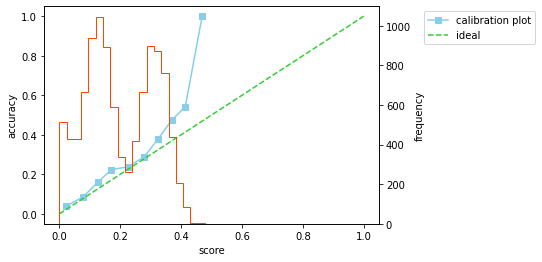

In [81]:
prob_true, prob_pred = calibration_curve(y_true=df_use.target, y_prob=df_use.buy_pred, n_bins=20)

fig, ax1 = plt.subplots()
ax1.plot(prob_pred, prob_true, marker='s', label='calibration plot', color='skyblue')
ax1.plot([0, 1], [0, 1], linestyle='--', label='ideal', color='limegreen')
ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
ax2 = ax1.twinx()
ax2.hist(df_use.buy_pred, bins=20, histtype='step', color='orangered')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('score')
ax2.set_ylabel('frequency')
# fig.savefig(log_path/'image/calibration_plot.png', bbox_inches='tight', pad_inche=.05)
plt.show()

In [82]:
df_use['target'] = df_use.odds * df_use.acc_flg

In [200]:
df_use['odds_buy'] = df_use.odds * df_use.buy_pred
df_use['odds_wh'] = df_use.odds * (df_use.score1 + df_use.buy_pred)

In [236]:
df_use['scores'] = df_use.score1 * df_use.buy_pred
df_use['score_p'] = df_use.score1 + df_use.buy_pred

In [286]:
df_use[['target']+X_cols].corr().style.background_gradient()

,target,score1,score2,s_diff,EV_diff,odds_1,odds1_score,odds_score_diff,odds_first,weather_int_2,weather_int_3,condition_int_2,condition_int_3,odds_score_diff_EV,odds1_EV,prob1_odds1_div,odds_div,o1_EV_diff,o1_EV_s_diff,odds_buy,score_p,buy_pred
target,1.000000,0.007295,0.016658,-0.007658,-0.014361,0.018709,0.023029,-0.023278,0.002886,-0.003470,0.014101,0.000084,0.001586,-0.020121,0.036734,-0.026978,-0.017522,-0.002391,0.005391,0.010219,0.008479,0.006923
score1,0.007295,1.000000,0.566061,0.606594,0.319626,-0.197288,0.636926,0.069709,0.205528,0.000313,0.017347,0.008527,0.021132,-0.067274,0.350346,-0.015504,-0.151888,0.145180,0.619402,0.246233,0.760969,0.375632
score2,0.016658,0.566061,1.000000,-0.312010,-0.111716,-0.051804,0.397903,-0.008889,-0.033288,0.007007,-0.005639,0.010135,0.010198,-0.030811,0.303203,-0.063519,-0.022267,0.087230,-0.156807,0.276684,0.349637,0.096756
s_diff,-0.007658,0.606594,-0.312010,1.000000,0.476106,-0.177415,0.350322,0.088912,0.268974,-0.006397,0.025430,0.000053,0.014520,-0.047820,0.111366,0.043389,-0.153576,0.083196,0.865084,0.016951,0.539829,0.339605
EV_diff,-0.014361,0.319626,-0.111716,0.476106,1.000000,0.042755,-0.070067,0.376374,-0.194335,0.004500,0.008127,-0.013801,-0.008728,0.602085,-0.017625,0.229430,0.410373,0.384468,0.372572,-0.325627,-0.044762,-0.291317
odds_1,0.018709,-0.197288,-0.051804,-0.177415,0.042755,1.000000,-0.304312,0.217424,-0.225673,0.010060,0.003378,0.005577,0.011931,0.050249,0.538237,0.176430,-0.097592,0.395408,0.035134,0.190576,-0.362972,-0.378144
odds1_score,0.023029,0.636926,0.397903,0.350322,-0.070067,-0.304312,1.000000,-0.724650,0.645729,-0.000977,0.022904,0.015584,0.021210,-0.372283,0.599274,-0.647112,-0.219539,-0.553132,0.535155,0.458175,0.833515,0.737545
odds_score_diff,-0.023278,0.069709,-0.008889,0.088912,0.376374,0.217424,-0.724650,1.000000,-0.651846,0.001543,-0.014132,-0.012543,-0.008556,0.421594,-0.462285,0.823496,0.148310,0.845519,-0.138811,-0.372770,-0.398340,-0.618603
odds_first,0.002886,0.205528,-0.033288,0.268974,-0.194335,-0.225673,0.645729,-0.651846,1.000000,-0.000717,0.021627,0.010289,0.009578,-0.328603,0.356458,-0.409526,-0.329670,-0.676403,0.374223,0.379009,0.723623,0.887459
weather_int_2,-0.003470,0.000313,0.007007,-0.006397,0.004500,0.010060,-0.000977,0.001543,-0.000717,1.000000,-0.127789,0.168060,0.101911,0.005239,0.004516,0.004867,-0.003358,0.002648,-0.002626,0.062935,0.024726,0.035097


In [285]:
X_cols=[
#     'odds',
#  'odds_rank',
 'score1',
 'score2',
 's_diff',
#  'EV',
 'EV_diff',
#  's_diff_rate',
 'odds_1',
 'odds1_score',
#  'odds_diff',
 'odds_score_diff',
 'odds_first',
 'weather_int_2',
 'weather_int_3',
 'condition_int_2',
 'condition_int_3',
 'odds_score_diff_EV',
 'odds1_EV',
 'prob1_odds1_div',
 'odds_div',
 'o1_EV_diff',
 'o1_EV_s_diff',
#  'buy_pred',
 'odds_buy',
# 'odds_wh',
#     'scores',
    'score_p',
    'buy_pred'
      ]

<AxesSubplot:>

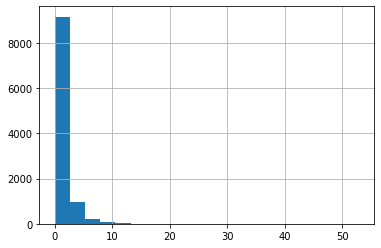

In [240]:
df_use.target.hist(bins=20)

<AxesSubplot:>

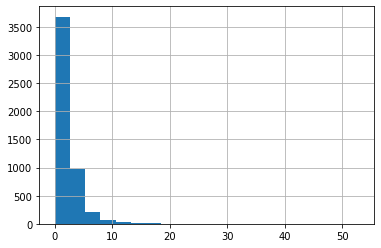

In [241]:
df_use2.target.hist(bins=20)

In [287]:
df_train_tmp, df_test = train_test_split(df_use.query('odds < 15'))
# 


df_train = pd.concat([
    df_train_tmp.loc[df_train_tmp.acc_flg==1],
    df_train_tmp.loc[df_train_tmp.acc_flg==0].sample(df_train_tmp.acc_flg.sum(), random_state=0)
])
print(df_train.shape)
print(df_test.shape)

(3668, 30)
(2455, 30)


In [288]:
# X_cols = [col for col in df_train.columns if col not in {'acc_flg', 'target'}]
print(len(X_cols))
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train['target']
y_test = df_test['target']

# X_train = df_use[X_cols]
# y_train = df_use['target']
# X_test = df_use[X_cols]
# y_test = df_use['target']

21


In [289]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test)

params = {
        'objective': 'reg:linear',
        'silent':0, 
        'gamma':10,
        'random_state':0, 
        # 学習用の指標 (RMSE)
        'eval_metric': 'logloss',
    }
num_round = 200
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [290]:
model = xgb.train(params,
                    dtrain,#訓練データ
                    num_round,#設定した学習回数
#                     early_stopping_rounds=20,
#                     evals=watchlist,
                    )

y_pred_prob = model.predict(dtest)
# prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)

# print(roc_auc_score(y_test, y_pred_prob))

[14:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [291]:
y_pred_prob

array([1.2017142, 2.318527 , 0.9652192, ..., 1.2756833, 1.9003129,
       1.7675537], dtype=float32)

In [292]:
df_test['pred'] = y_pred_prob

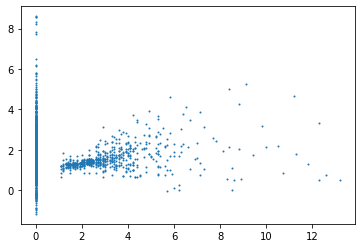

In [293]:
plt.scatter(df_test.target, df_test.pred, s=1)

In [294]:
df_test.pred.max()

8.614614

対象カラム: pred, 最大回収率: 0.958, 閾値: 4.6, 対象数: 36, 対象率: 0.015


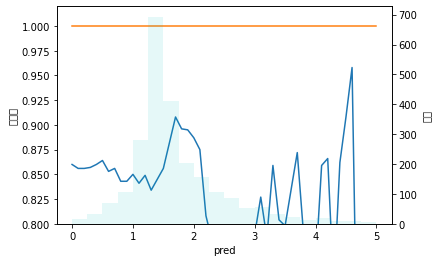

In [295]:
df_ret, max_th = get_return(df_test, 'pred', 5, 0.1, over=True, plot_min=0.8)

In [296]:
from sklearn.linear_model import LinearRegression

In [297]:
lr = LinearRegression()

In [298]:
lr.fit(X_train, y_train)

LinearRegression()

In [299]:
lr.score(X_train, y_train)

0.03195338521406976

In [300]:
lr.predict(X_test)

array([1.59108885, 1.54989857, 1.04000689, ..., 1.30459937, 1.92843566,
       1.85687629])

In [301]:
lr.score(X_test, y_test)

-0.2595861742519765

In [302]:
(pd.Series(lr.coef_, X_train.columns)).to_frame()

,0
score1,3.962273
score2,1.404722
s_diff,2.557551
EV_diff,-0.965411
odds_1,0.042318
odds1_score,4.348395
odds_score_diff,-0.386122
odds_first,0.603415
weather_int_2,0.131055
weather_int_3,-0.024874


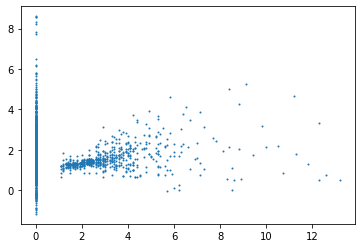

In [303]:
plt.scatter(df_test.target, df_test.pred, s=1)

<AxesSubplot:>

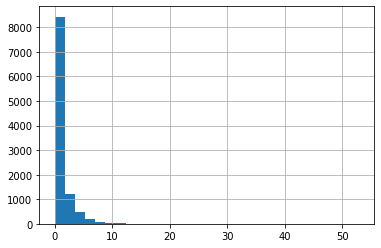

In [304]:
df_use.target.hist(bins=30)

対象カラム: pred, 最大回収率: 0.958, 閾値: 4.6, 対象数: 36, 対象率: 0.015


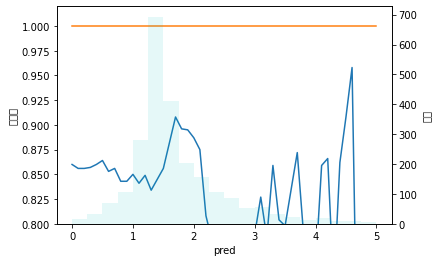

In [305]:
df_ret, max_th = get_return(df_test, 'pred', 5, 0.1, over=True, plot_min=0.8)

acc_flg
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

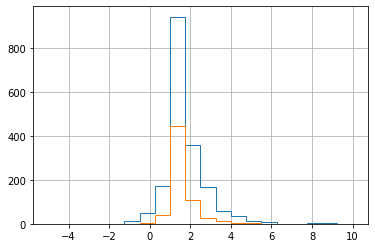

In [306]:
df_test.groupby('acc_flg').pred.hist(bins=20, histtype='step', range=(-5, 10))